# 1. Setup

In [1]:
install.packages("ggbeeswarm")
install.packages("ggridges")
install.packages("patchwork")
install.packages("ggbump")
install.packages("cowplot")
install.packages("svglite")
install.packages("survRM2")
install.packages("forcats")
install.packages("ggh4x")
install.packages("scales")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘beeswarm’, ‘vipor’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(ggplot2)
library(dplyr)
library(repr)
library(ggbeeswarm)
library(ggridges)
library(patchwork)
library(ggbump)
library(cowplot)
library(svglite)
library(survival)
library(survRM2)
library(tidyr)
library(forcats)
library(ggh4x)
library(scales)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




# 2. Read in Files

## 2.1 Full Dataset Performance Files

In [3]:
# Define directory where files are stored
dir <- "Benchmarking/Results"

# List all files in the directory
files <- system(paste0("dx ls ", dir), intern = TRUE)

# Filter for performance files based on expected patterns
performance_files <- files[grepl("_performance.tsv", files)]

# Initialize lists to store merged dataframes for each endpoint
merged_performance_dataframes <- list()

# Loop through each performance file to download and process
for (perf_entry in performance_files) {
  # Split entry to extract filename and file ID (if available)
  parts <- strsplit(perf_entry, " : ")[[1]]
  file_name <- parts[1]
  file_id <- ifelse(length(parts) > 1, parts[2], NA)
  
  # Download the file by ID if available, otherwise by name
  if (!is.na(file_id)) {
    download_cmd <- paste("dx download", file_id, "-o", file_name)
  } else {
    download_cmd <- paste("dx download", paste0(dir, "/", file_name))
  }
  system(download_cmd)
  
  # Read the file into a dataframe
  perf_data <- read.csv(file_name, sep = "\t", header = TRUE)
  
  # Extract metadata from the filename
  name_parts <- strsplit(file_name, "_")[[1]]
  model_type <- name_parts[1]
  endpoint <- name_parts[2]
  combo_name <- paste(name_parts[3:(length(name_parts) - 2)], collapse = "_")
  cv_split <- sub("cvsplit", "", name_parts[length(name_parts) - 1])
  
  # Add metadata columns to dataframe
  perf_data$model_type <- model_type
  perf_data$endpoint <- endpoint
  perf_data$combo_name <- combo_name
  perf_data$cv_split <- as.numeric(cv_split)
  
  # Merge performance data by endpoint
  if (!is.null(merged_performance_dataframes[[endpoint]])) {
    merged_performance_dataframes[[endpoint]] <- rbind(
      merged_performance_dataframes[[endpoint]], 
      perf_data
    )
  } else {
    merged_performance_dataframes[[endpoint]] <- perf_data
  }
  
  # Clean up by removing the downloaded file
  unlink(file_name)
}

# Combine all endpoint-specific dataframes into one
final_performance_df <- do.call(rbind, merged_performance_dataframes)

# Display the first few rows
head(final_performance_df)


,cv_split,c_index,model_type,endpoint,combo_name
,<dbl>,<chr>,<chr>,<chr>,<chr>
AD.1,1,0.81833776332153,Cox,AD,agesex_cvsplit
AD.2,2,0.819479698336396,Cox,AD,agesex_cvsplit
AD.3,3,0.817879603646329,Cox,AD,agesex_cvsplit
AD.4,4,0.820764176637176,Cox,AD,agesex_cvsplit
AD.5,5,0.825140862763045,Cox,AD,agesex_cvsplit
AD.6,1,0.830955902700319,Cox,AD,clinicalrisk_cvsplit


In [4]:
# Ensure c_index is numeric and cleaned
final_performance_df$c_index <- as.numeric(gsub("tensor\\(|\\)", "", final_performance_df$c_index))
final_performance_df$c_index <- round(final_performance_df$c_index, 4)

# Step 1: Extract Cox model c_index for each endpoint, cv_split, and combo_name
cox_reference <- final_performance_df %>%
  filter(model_type == "Cox") %>%
  select(endpoint, cv_split, combo_name, cox_c_index = c_index)

# Step 2: Join back only for non-Cox models and calculate delta_c
final_performance_df <- final_performance_df %>%
  left_join(cox_reference, by = c("endpoint", "cv_split", "combo_name")) %>%
  mutate(delta_c = if_else(model_type == "Cox", 0, round(c_index - cox_c_index, 4)))

# Display the updated dataframe
head(final_performance_df)


,cv_split,c_index,model_type,endpoint,combo_name,cox_c_index,delta_c
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,1,0.8183,Cox,AD,agesex_cvsplit,0.8183,0
2,2,0.8195,Cox,AD,agesex_cvsplit,0.8195,0
3,3,0.8179,Cox,AD,agesex_cvsplit,0.8179,0
4,4,0.8208,Cox,AD,agesex_cvsplit,0.8208,0
5,5,0.8251,Cox,AD,agesex_cvsplit,0.8251,0
6,1,0.8310,Cox,AD,clinicalrisk_cvsplit,0.8310,0


In [5]:
# Step 3: Summarize to calculate mean and SD of delta_c by model_type, endpoint, and combo_name
summary_df <- final_performance_df %>%
  group_by(model_type, endpoint, combo_name) %>%
  summarise(
    mean_delta_c = round(mean(delta_c, na.rm = TRUE), 4),
    sd_delta_c = round(sd(delta_c, na.rm = TRUE), 4),
    .groups = 'drop'
  )


## 2.2: Read in timings data

In [7]:
# Define directory where files are stored
dir <- "Benchmarking/Results"

# List all files in the directory
files <- system(paste0("dx ls ", dir), intern = TRUE)

# Filter for timings files based on expected patterns
timings_files <- files[grepl("_timings.tsv", files)]

# Initialize lists to store merged dataframes for each endpoint
merged_timings_dataframes <- list()

# Loop through each timings file to download and process
for (perf_entry in timings_files) {
  # Split entry to extract filename and file ID (if available)
  parts <- strsplit(perf_entry, " : ")[[1]]
  file_name <- parts[1]
  file_id <- ifelse(length(parts) > 1, parts[2], NA)
  
  # Download the file by ID if available, otherwise by name
  if (!is.na(file_id)) {
    download_cmd <- paste("dx download", file_id, "-o", file_name)
  } else {
    download_cmd <- paste("dx download", paste0(dir, "/", file_name))
  }
  system(download_cmd)
  
  # Read the file into a dataframe
  perf_data <- read.csv(file_name, sep = "\t", header = TRUE)
  
  # Ensure all expected columns are present
  # If columns are missing, add them with NA values
  if (!"cv_time" %in% colnames(perf_data)) {
    perf_data$cv_time <- NA
  }
  if (!"refit_time" %in% colnames(perf_data)) {
    perf_data$refit_time <- NA
  }
  if (!"fit_time" %in% colnames(perf_data)) {
    perf_data$fit_time <- NA
  }
  
  # Add the 'once_time' column
  # 'once_time' takes the value of 'fit_time' if it exists; otherwise, it takes 'refit_time', needs to be done bc of the COX-PH benchmark without hyperparam opt
  perf_data$once_time <- ifelse(!is.na(perf_data$fit_time), perf_data$fit_time, perf_data$refit_time)
  
  # Extract metadata from the filename
  name_parts <- strsplit(file_name, "_")[[1]]
  model_type <- name_parts[1]
  endpoint <- name_parts[2]
  combo_name <- paste(name_parts[3:(length(name_parts) - 2)], collapse = "_")
  # combo_name <- sub("_cvsplit$", "", combo_name)  # Remove '_cvsplit' suffix from combo_name
  cv_split <- sub("cvsplit", "", name_parts[length(name_parts) - 1])
  
  # Add metadata columns to dataframe
  perf_data$model_type <- model_type
  perf_data$endpoint <- endpoint
  perf_data$combo_name <- combo_name
  perf_data$cv_split <- as.numeric(cv_split)
  
  # Merge timings data by endpoint
  if (!is.null(merged_timings_dataframes[[endpoint]])) {
    merged_timings_dataframes[[endpoint]] <- rbind(
      merged_timings_dataframes[[endpoint]], 
      perf_data
    )
  } else {
    merged_timings_dataframes[[endpoint]] <- perf_data
  }
  
  # Clean up by removing the downloaded file
  unlink(file_name)
}

# Combine all endpoint-specific dataframes into one
final_timings_df <- do.call(rbind, merged_timings_dataframes)

## 2.3: Read in cvresults data (param_sets and detailed results)

In [9]:
# Define directory where files are stored
dir <- "Benchmarking/Results"

# List all files in the directory
files <- system(paste0("dx ls ", dir), intern = TRUE)

# Filter for cvresults files based on expected patterns
cvresults_files <- files[grepl("_cvresults.tsv$", files)]

# Initialize lists to store merged dataframes for each model_type
merged_cvresults_dataframes <- list()

# Loop through each cvresults file to download and process
for (perf_entry in cvresults_files) {
  # Split entry to extract filename and file ID (if available)
  parts <- strsplit(perf_entry, " : ")[[1]]
  file_name <- parts[1]
  file_id <- ifelse(length(parts) > 1, parts[2], NA)
  
  # Download the file by ID if available, otherwise by name
  if (!is.na(file_id)) {
    download_cmd <- paste("dx download", file_id, "-o", file_name)
  } else {
    download_cmd <- paste("dx download", paste0(dir, "/", file_name))
  }
  system(download_cmd)
  
  # Read the file into a dataframe
  perf_data <- read.csv(file_name, sep = "\t", header = TRUE)
  
  # Extract metadata from the filename
  name_parts <- strsplit(file_name, "_")[[1]]
  model_type <- name_parts[1]
  endpoint <- name_parts[2]
  combo_name <- paste(name_parts[3:(length(name_parts) - 2)], collapse = "_")
  cv_split <- sub("cvsplit", "", name_parts[length(name_parts) - 1])
  
  # Add metadata columns to dataframe
  perf_data$model_type <- model_type
  perf_data$endpoint <- endpoint
  perf_data$combo_name <- combo_name
  perf_data$cv_split <- as.numeric(cv_split)
  
  # Merge cvresults data by model_type
  if (!is.null(merged_cvresults_dataframes[[model_type]])) {
    merged_cvresults_dataframes[[model_type]] <- rbind(
      merged_cvresults_dataframes[[model_type]], 
      perf_data
    )
  } else {
    merged_cvresults_dataframes[[model_type]] <- perf_data
  }
  
  # Clean up by removing the downloaded file
  unlink(file_name)
}

# Print available dataframes
print(names(merged_cvresults_dataframes))

[1] "DL"       "EN"       "Lasso"    "lightGBM" "RangerRF" "Ridge"    "XGB"     


## 2.4 Full Dataset LP files

### 2.4.1 Read in LP files

In [ ]:
# Define directory where files are stored
dir <- "Benchmarking/Results"

# List all files in the directory
files <- system(paste0("dx ls ", dir), intern = TRUE)

# Filter for LP files based on expected pattern
lp_files <- files[grepl("_LP.tsv$", files)]

# Initialize list to store dataframes from each LP file
lp_data_list <- list()

# Loop through each LP file to download, process, and merge
for (lp_entry in lp_files) {
  # The 'lp_entry' might look like: "Cox_AD_prs_metabolomics_cvsplit_1_train_LP.tsv : file-XXXX"
  # We split on " : " to separate the local filename from the DNAnexus file ID (if present).
  parts <- strsplit(lp_entry, " : ")[[1]]
  file_name <- parts[1]
  file_id   <- ifelse(length(parts) > 1, parts[2], NA)
  
  # Download the file by ID if available, otherwise by name
  if (!is.na(file_id)) {
    download_cmd <- paste("dx download", file_id, "-o", shQuote(file_name))
  } else {
    download_cmd <- paste("dx download", shQuote(file.path(dir, file_name)))
  }
  system(download_cmd)
  
  # Read the file into a dataframe
  lp_data <- read.csv(file_name, sep = "\t", header = TRUE)
  
  # Split filename by underscores
  name_parts <- strsplit(file_name, "_")[[1]]
  # Example: c("Cox", "AD", "prs", "metabolomics", "cvsplit", "1", "train", "LP.tsv")
  
  # 1) model_type = first part
  model_type <- name_parts[1]
  
  # 2) endpoint = second part
  endpoint   <- name_parts[2]
  
  # 3) find where "cvsplit" occurs
  cvsplit_index <- which(name_parts == "cvsplit")
  if (length(cvsplit_index) != 1) {
    stop(paste("Could not find exactly one 'cvsplit' token in filename:", file_name))
  }
  
  # 4) combo_name = everything from the 3rd element up to (cvsplit_index - 1), joined by underscores
  if (cvsplit_index <= 3) {
    stop(paste("No room for combo_name between endpoint and cvsplit in:", file_name))
  }
  combo_vec  <- name_parts[3:(cvsplit_index - 1)]
  combo_name <- paste(combo_vec, collapse = "_")
  
  # 5) The element immediately after "cvsplit" is the numeric CV split
  #    e.g. name_parts[cvsplit_index + 1] should be "1"
  if ((cvsplit_index + 1) > length(name_parts)) {
    stop(paste("No number after 'cvsplit' in filename:", file_name))
  }
  cv_split_raw <- name_parts[cvsplit_index + 1]
  cv_split <- suppressWarnings(as.numeric(cv_split_raw))
  if (is.na(cv_split)) {
    stop(paste("Failed to parse cv_split as numeric from:", cv_split_raw, "in filename:", file_name))
  }
  
  # 6) The element after cv_split is "train" or "test" (assuming 2 more tokens remain)
  #    e.g. name_parts[cvsplit_index + 2] should be "train" or "test"
  if ((cvsplit_index + 2) > length(name_parts)) {
    stop(paste("No train/test token after cvsplit number in filename:", file_name))
  }
  train_or_test <- name_parts[cvsplit_index + 2]
  if (!(train_or_test %in% c("train", "test"))) {
    stop(paste("Filename doesn't match expected pattern (train/test) in:", file_name))
  }
  
  # 7) The last element might be "LP.tsv"; we can validate or ignore
  #    If there are more tokens, we can check if the last is "LP.tsv".
  #    For safety:
  if (!grepl("^LP\\.tsv$", name_parts[length(name_parts)])) {
    warning(paste("Last token isn't 'LP.tsv' as expected in:", file_name))
  }
  
  # Add metadata columns
  lp_data$model_type <- model_type
  lp_data$endpoint   <- endpoint
  lp_data$combo_name <- combo_name
  lp_data$cv_split   <- cv_split
  lp_data$testtrain  <- train_or_test
  
  # Append this to our list
  lp_data_list[[length(lp_data_list) + 1]] <- lp_data
  
  # Clean up by removing the downloaded file
  unlink(file_name)
}

# Combine all dataframes into one big dataframe
final_lp_df <- do.call(rbind, lp_data_list)

# Show the first few rows
head(final_lp_df)

### 2.4.2 Read in endpoint files

In [10]:
# Define file and endpoint
endpointsfile <- "UKBRISK/to_event_Touchscreen_v3.tsv"  
endpoints <- c("CVD", "BC", "AD")  

# Download and load the dataset once
download_cmd <- paste("dx download", shQuote(endpointsfile), "--overwrite")
system(download_cmd)
df <- read.csv(basename(endpointsfile), sep = "\t", header = TRUE)

# Round continuous variables to 2 decimal places
numeric_cols <- sapply(df, is.numeric)
df[, numeric_cols] <- round(df[, numeric_cols], 2)

# Initialize a list to store labels for each endpoint
labels_list <- list()

for(endpoint in endpoints) {
  # Endpoint-specific exclusion - baseline endpoint status
  base_col <- paste0(endpoint, "_at_base")
  eids_to_include <- df %>% filter(.data[[base_col]] == FALSE) %>% pull(eid)
  df_filtered <- df %>% filter(eid %in% eids_to_include)
  cat("Endpoint:", endpoint, "- Retained n =", length(eids_to_include), 
      "individuals due to criteria: past occurrence of endpoint\n")
  
  # Create labels dataframe for current endpoint
  status_col <- paste0(endpoint, "_status")
  followup_col <- paste0(endpoint, "_followup")
  label_cols <- c(status_col, followup_col, "eid")
  endpoint_labels <- df_filtered %>% select(all_of(label_cols))
  rownames(endpoint_labels) <- endpoint_labels$eid
  
  # Store in list
  labels_list[[endpoint]] <- endpoint_labels
}

Endpoint: CVD - Retained n = 466311 individuals due to criteria: past occurrence of endpoint
Endpoint: BC - Retained n = 490944 individuals due to criteria: past occurrence of endpoint
Endpoint: AD - Retained n = 502231 individuals due to criteria: past occurrence of endpoint


### 2.4.3 Merge predictions and labels

In [11]:
# Iterate through each endpoint and merge its labels into LP_df
for (endpoint in endpoints) {
  # Extract the labels dataframe for the current endpoint
  endpoint_labels <- labels_list[[endpoint]]
  
  # Ensure endpoint_labels contains the necessary columns
  if (!is.null(endpoint_labels) && all(c(paste0(endpoint, "_status"), paste0(endpoint, "_followup")) %in% colnames(endpoint_labels))) {
    # Merge by 'eid', adding status and followup to LP_df
    LP_df <- LP_df %>%
      left_join(
        endpoint_labels %>% select(eid, starts_with(endpoint)),
        by = "eid"
      )
  } else {
    warning(paste("Labels for endpoint", endpoint, "are missing or incomplete. Skipping this endpoint."))
  }
}

# Check the first few rows to ensure proper merging
head(LP_df)

,eid,LP,model_type,endpoint,combo_name,cv_split,testtrain,CVD_status,CVD_followup,BC_status,BC_followup,AD_status,AD_followup
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<lgl>,<dbl>,<lgl>,<dbl>,<lgl>,<dbl>
1,1000102,1.450167,Cox,AD,agesex,1,test,TRUE,7.82,FALSE,12.37,FALSE,12.37
2,1000184,-2.938897,Cox,AD,agesex,1,test,FALSE,12.59,FALSE,12.59,FALSE,12.59
3,1000333,2.295603,Cox,AD,agesex,1,test,TRUE,10.55,FALSE,13.89,FALSE,13.89
4,1000440,2.295603,Cox,AD,agesex,1,test,FALSE,13.22,FALSE,13.22,FALSE,13.22
5,1000553,1.167507,Cox,AD,agesex,1,test,TRUE,1.54,FALSE,12.04,FALSE,12.04
6,1000710,2.295603,Cox,AD,agesex,1,test,FALSE,14.12,FALSE,14.12,FALSE,14.12


## 2.5 Perform performance evaluation

In [12]:
LP_df <- LP_df %>%
  mutate(inv_LP = -LP)

In [13]:
pick_endpoint_cols <- function(endpoint) {
  if (endpoint == "AD") {
    list(status_col = "AD_status", time_col = "AD_followup")
  } else if (endpoint == "CVD") {
    list(status_col = "CVD_status", time_col = "CVD_followup")
  } else if (endpoint == "BC") {
    list(status_col = "BC_status", time_col = "BC_followup")
  } else {
    stop("Unknown endpoint")
  }
}

In [14]:
# Define the Processing Function for Each Group
process_group <- function(group_data) {
  

  # Step 1: Extract Endpoint-Specific Columns
  ep_cols <- pick_endpoint_cols(unique(group_data$endpoint))
  status_col <- ep_cols$status_col
  time_col   <- ep_cols$time_col
  
  # Step 2: Split Data into Training and Test Sets
  train_data <- group_data %>% filter(testtrain != "test")
  test_data  <- group_data %>% filter(testtrain == "test")
  
  # Step 3: Convert Relevant Columns to Numeric
  train_time   <- as.numeric(train_data[[time_col]])
  train_status <- as.numeric(train_data[[status_col]])
  
  test_time    <- as.numeric(test_data[[time_col]])
  test_status  <- as.numeric(test_data[[status_col]])
  test_lp      <- as.numeric(test_data$LP)
  test_inv_lp  <- as.numeric(test_data$inv_LP)  
  
  # Step 4: Create Surv Objects
  surv_train <- Surv(train_time, train_status)
  surv_test  <- Surv(test_time, test_status)
  
  # Step 5: Compute C
  c_index_train <- concordance(surv_train ~ train_data$inv_LP)$concordance
  c_index_test <- concordance(surv_test ~ test_inv_lp)$concordance
  delta_c <- c_index_train - c_index_test
  uno_c_test <- concordance(surv_test ~ test_inv_lp, timewt= "n/G2")$concordance
  
  # Step 6: Compute Additional Metrics for Top 20% and Top 10%
  decile_thresh_20 <- quantile(test_lp, 0.8, na.rm = TRUE)
  top_decile_20    <- ifelse(test_lp >= decile_thresh_20, 1, 0)
  
  # Confusion Matrix Elements for Top 20%
  actual_event <- test_status
  TP_20 <- sum(top_decile_20 == 1 & actual_event == 1)
  FP_20 <- sum(top_decile_20 == 1 & actual_event == 0)
  TN_20 <- sum(top_decile_20 == 0 & actual_event == 0)
  FN_20 <- sum(top_decile_20 == 0 & actual_event == 1)
  
  # Metrics for Top 20%
  sens_20 <- ifelse((TP_20 + FN_20) > 0, TP_20 / (TP_20 + FN_20), NA)
  spec_20 <- ifelse((TN_20 + FP_20) > 0, TN_20 / (TN_20 + FP_20), NA)
  fpr_20  <- ifelse((FP_20 + TN_20) > 0, FP_20 / (FP_20 + TN_20), NA)
  fnr_20  <- ifelse((TP_20 + FN_20) > 0, FN_20 / (TP_20 + FN_20), NA)
  
  # Log-rank Test for Top 20%
  logrank_fit_20 <- survdiff(surv_test ~ top_decile_20)
  pval_lr_20 <- 1 - pchisq(logrank_fit_20$chisq, df = length(logrank_fit_20$n) - 1)
  
  # RMST at 10 Years for Top 20%
  rmst_result_20 <- rmst2(time = test_time, status = test_status, arm = top_decile_20, tau = 10)
  rmst_diff_20    <- rmst_result_20$unadjusted.result["RMST (arm=1)-(arm=0)", "Est."]
  rmst_pval_20    <- rmst_result_20$unadjusted.result["RMST (arm=1)-(arm=0)", "p"]
  
  # Cox Proportional Hazards Model for Top 20%
  cox_fit_20 <- coxph(surv_test ~ top_decile_20)
  summary_cox_20 <- summary(cox_fit_20)
  
  hr_20        <- summary_cox_20$conf.int["top_decile_20", "exp(coef)"]
  lower_ci_20  <- summary_cox_20$conf.int["top_decile_20", "lower .95"]
  upper_ci_20  <- summary_cox_20$conf.int["top_decile_20", "upper .95"]
  hr_pval_20   <- summary_cox_20$coefficients["top_decile_20", "Pr(>|z|)"]
  
  # Top 10% Thresholding
  decile_thresh_10 <- quantile(test_lp, 0.9, na.rm = TRUE)
  top_decile_10    <- ifelse(test_lp >= decile_thresh_10, 1, 0)
  
  # Confusion Matrix Elements for Top 10%
  TP_10 <- sum(top_decile_10 == 1 & actual_event == 1)
  FP_10 <- sum(top_decile_10 == 1 & actual_event == 0)
  TN_10 <- sum(top_decile_10 == 0 & actual_event == 0)
  FN_10 <- sum(top_decile_10 == 0 & actual_event == 1)
  
  # Calculate Metrics for Top 10%
  sens_10 <- ifelse((TP_10 + FN_10) > 0, TP_10 / (TP_10 + FN_10), NA)
  spec_10 <- ifelse((TN_10 + FP_10) > 0, TN_10 / (TN_10 + FP_10), NA)
  fpr_10  <- ifelse((FP_10 + TN_10) > 0, FP_10 / (FP_10 + TN_10), NA)
  fnr_10  <- ifelse((TP_10 + FN_10) > 0, FN_10 / (TP_10 + FN_10), NA)
  
  # Log-rank Test for Top 10%
  logrank_fit_10 <- survdiff(surv_test ~ top_decile_10)
  pval_lr_10 <- 1 - pchisq(logrank_fit_10$chisq, df = length(logrank_fit_10$n) - 1)
  
  # RMST at 10 Years for Top 10%
  rmst_result_10 <- rmst2(time = test_time, status = test_status, arm = top_decile_10, tau = 10)
  rmst_diff_10    <- rmst_result_10$unadjusted.result["RMST (arm=1)-(arm=0)", "Est."]
  rmst_pval_10    <- rmst_result_10$unadjusted.result["RMST (arm=1)-(arm=0)", "p"]
  
  # Cox Proportional Hazards Model for Top 10%
  cox_fit_10 <- coxph(surv_test ~ top_decile_10)
  summary_cox_10 <- summary(cox_fit_10)
  
  hr_10        <- summary_cox_10$conf.int["top_decile_10", "exp(coef)"]
  lower_ci_10  <- summary_cox_10$conf.int["top_decile_10", "lower .95"]
  upper_ci_10  <- summary_cox_10$conf.int["top_decile_10", "upper .95"]
  hr_pval_10   <- summary_cox_10$coefficients["top_decile_10", "Pr(>|z|)"]
  
  #Step 7: Compile Results
  
  results <- data.frame(
    # Harrell’s C-index
    c_index_train  = c_index_train,
    c_index_test   = c_index_test,
    delta_c        = delta_c,
    # Uno’s C-index
    uno_c      = uno_c_test,
    # Top 20% Metrics
    chisq_20        = logrank_fit_20$chisq,
    sensitivity_20  = sens_20,
    specificity_20  = spec_20,
    fpr_20          = fpr_20,
    fnr_20          = fnr_20,
    logrank_p_val_20 = sprintf("%.16f", pval_lr_20),
    hr_20            = hr_20,
    hr_lower_ci_20   = lower_ci_20,
    hr_upper_ci_20   = upper_ci_20,
    hr_pval_20       = sprintf("%.16f", hr_pval_20),
    rmst_diff_20     = rmst_diff_20,
    rmst_pval_20     = sprintf("%.16f", rmst_pval_20),
    # Top 10% Metrics
    chisq_10        = logrank_fit_10$chisq,
    sensitivity_10  = sens_10,
    specificity_10  = spec_10,
    fpr_10          = fpr_10,
    fnr_10          = fnr_10,
    logrank_p_val_10 = sprintf("%.16f", pval_lr_10),
    hr_10            = hr_10,
    hr_lower_ci_10   = lower_ci_10,
    hr_upper_ci_10   = upper_ci_10,
    hr_pval_10       = sprintf("%.16f", hr_pval_10),
    rmst_diff_10     = rmst_diff_10,
    rmst_pval_10     = sprintf("%.16f", rmst_pval_10)
  )
  
  return(results)
}

In [15]:
#apply processing
results <- LP_df %>%
  group_by(cv_split, model_type, endpoint, combo_name) %>%
  do(process_group(.)) %>%
  ungroup()

In [14]:
write.table(results, "results_perf.tsv", sep = "\t", row.names = FALSE, quote = FALSE)

system("dx upload results_perf.tsv --path Benchmarking/Plots/results_perf.tsv")

### 2.5.1 Can DL from here

In [3]:
system("dx download Benchmarking/Plots/results_perf.tsv -o downloaded_results_perf2.tsv")
results <- read.table("downloaded_results_perf2.tsv", sep = "\t", header = TRUE)
head(results)

,cv_split,model_type,endpoint,combo_name,c_index_train,c_index_test,delta_c,uno_c,chisq_20,sensitivity_20,⋯,specificity_10,fpr_10,fnr_10,logrank_p_val_10,hr_10,hr_lower_ci_10,hr_upper_ci_10,hr_pval_10,rmst_diff_10,rmst_pval_10
,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,Cox,AD,agesex,0.8215526,0.8183378,0.003214790,0.8349790,444.84132,0.6270270,⋯,0.8981106,0.10188940,0.6000000,0.000000000,6.328312,5.139642,7.791892,0.000000000,-0.02685881,1.890388e-07
2,1,Cox,AD,clinicalrisk,0.8425921,0.8309559,0.011636174,0.8515589,499.24051,0.6324324,⋯,0.9024579,0.09754211,0.5810811,0.000000000,7.361114,5.986615,9.051191,0.000000000,-0.02866641,2.502030e-08
3,1,Cox,AD,everything,0.8831058,0.8683380,0.014767849,0.8833318,861.59381,0.7729730,⋯,0.9035656,0.09643439,0.4378378,0.000000000,13.278892,10.811507,16.309380,0.000000000,-0.04146502,1.450100e-11
4,1,Cox,AD,pmh,0.8309989,0.8185526,0.012446310,0.8331651,468.93041,0.6324324,⋯,0.9021862,0.09781382,0.6162162,0.000000000,6.307689,5.114863,7.778691,0.000000000,-0.02403150,1.633003e-06
5,1,Cox,AD,prs_metabolomics,0.8716310,0.8644288,0.007202283,0.8702061,830.30141,0.7648649,⋯,0.9035656,0.09643439,0.4378378,0.000000000,13.138751,10.698022,16.136328,0.000000000,-0.04200113,3.971900e-12
6,1,Cox,BC,agesex,0.5356915,0.5444747,-0.008783186,0.5447170,12.79255,0.2530120,⋯,0.8699096,0.13009040,0.8443003,0.003991972,1.272724,1.079583,1.500419,0.004080671,-0.04010910,4.952480e-02


### 2.5.2 Merge in timing data & Recoding

In [17]:
final_timings_df <- final_timings_df %>%
  mutate(
    combo_name = sub("_cvsplit$", "", combo_name)  # remove trailing "_cvsplit"
  ) %>%
  select(
    cv_split, model_type, endpoint, combo_name, once_time  # keep only once_time
  )

results_with_timings <- results %>%
  left_join(final_timings_df,
            by = c("cv_split", "model_type", "endpoint", "combo_name"))

In [18]:
# Recoding
results_with_timings <- results_with_timings %>%
  mutate(
    # Recoding 'endpoint' to descriptive labels
    endpoint = recode(endpoint,
                      "CVD" = "Cardiovascular Disease",
                      "AD"  = "Alzheimer's Disease", 
                      "BC"  = "Breast Cancer",
                      .default = endpoint
    ),
    
    # Recoding 'model_type' to descriptive labels
    model_type = recode(model_type,
                        "Cox"       = "Cox",
                        "DL"        = "Deep Learning",
                        "EN"        = "Elastic Net",
                        "Lasso"     = "Lasso",
                        "lightGBM"  = "Gradient Boosting Machine",
                        "RangerRF"  = "Random Forest",
                        "Ridge"     = "Ridge",
                        "XGB"       = "XGBoost",
                        .default = model_type
    ),
    
    # Recoding 'combo_name' to descriptive labels
    combo_name = recode(combo_name,
                         "agesex"           = "Age & Sex",
                         "clinicalrisk"     = "Clinical Risk",
                         "everything"       = "Everything",
                         "pmh"              = "Past Medical History",
                         "prs_metabolomics" = "PRS & Metabolomics",
                         .default = combo_name  # Retain original if no match
    )
)

### 2.5.3 Generate Supplementary Table

In [40]:
# select metric columns
metrics <- setdiff(names(results_with_timings), c("cv_split", "model_type", "endpoint", "combo_name"))

In [41]:
mean_ci <- function(x) {
  m <- mean(x, na.rm = TRUE)
  se <- sd(x, na.rm = TRUE) / sqrt(length(x))
  lower <- m - 1.96 * se
  upper <- m + 1.96 * se
  return(sprintf("%.3f [%.3f, %.3f]", m, lower, upper))
}

In [42]:
df_summary_supp <- results_with_timings %>%
  group_by(model_type, endpoint, combo_name) %>%
  summarize(across(all_of(metrics), mean_ci)) %>%
  ungroup()

`summarise()` has grouped output by 'model_type', 'endpoint'. You can override
using the `.groups` argument.


In [46]:
# Identify unique endpoints
unique_endpoints <- unique(df_summary_supp$endpoint)

# Function to sanitize endpoint names for filenames
sanitize_filename <- function(name) {
  # Replace non-alphanumeric characters with underscores
  safe_name <- gsub("[^A-Za-z0-9]", "_", name)
  # Replace multiple underscores with a single underscore
  safe_name <- gsub("_+", "_", safe_name)
  # Trim leading and trailing underscores
  safe_name <- gsub("^_|_$", "", safe_name)
  return(safe_name)
}

# Loop through each unique endpoint
for (ep in unique_endpoints) {
  # Sanitize the endpoint name
  safe_ep <- sanitize_filename(ep)
  
  # Create a filtered dataframe for the current endpoint
  df_split <- df_summary_supp %>% filter(endpoint == ep)
  
  # Define the sanitized filename (e.g., "df_AD_summary.tsv")
  filename <- paste0("df_", safe_ep, "_summary.tsv")
  
  # Write the split dataframe to a TSV file
  write.table(df_split, file = filename, sep = "\t", row.names = FALSE, quote = FALSE)
  
  # Define the destination path on DNAnexus
  # Adjust "Benchmarking/Plots/" to your actual DNAnexus project folder path if different
  dnax_destination <- paste0("Benchmarking/Plots/", filename)
  
  # Construct the dx upload command
  dx_command <- paste("dx upload", shQuote(filename), "--path", shQuote(dnax_destination))
  
  # Execute the upload command
  system(dx_command)
  
  # Print a confirmation message
  message("Uploaded ", filename, " to DNAnexus at ", dnax_destination)
}

Uploaded df_Alzheimer_s_Disease_summary.tsv to DNAnexus at Benchmarking/Plots/df_Alzheimer_s_Disease_summary.tsv

Uploaded df_Breast_Cancer_summary.tsv to DNAnexus at Benchmarking/Plots/df_Breast_Cancer_summary.tsv

Uploaded df_Cardiovascular_Disease_summary.tsv to DNAnexus at Benchmarking/Plots/df_Cardiovascular_Disease_summary.tsv



# 3. Plots: General Stuff colors, shapes, etc

In [20]:
model_colors <- c(
  "Cox" = "#FF5733",  
  "Deep Learning" = "#D7BDE2",
  "Elastic Net" = "#FADBD8",
  "Lasso" = "#F9E79F",
  "Gradient Boosting Machine" = "#85C1E9",
  "Random Forest" = "#9B59B6",
  "Ridge" = "#A3E4D7",
  "XGBoost" = "#F1948A"
)

In [21]:
unique_endpoints <- unique(results_with_timings$endpoint)
num_shapes <- length(unique_endpoints)

available_shapes <- 21:25

shape_values <- available_shapes[1:num_shapes]
names(shape_values) <- unique_endpoints

# 4. Plots: Full Dataset

## 3.1 absolute performance

[1] "Age & Sex"
[1] "Clinical Risk"


Warning message in geom_quasirandom(data = plot_df, aes(x = c_index_test, y = endpoint, :
“Ignoring unknown parameters: `position`”
Orientation inferred to be along y-axis; override with
`position_quasirandom(orientation = 'x')`


[1] "Everything"
[1] "Past Medical History"
[1] "PRS & Metabolomics"


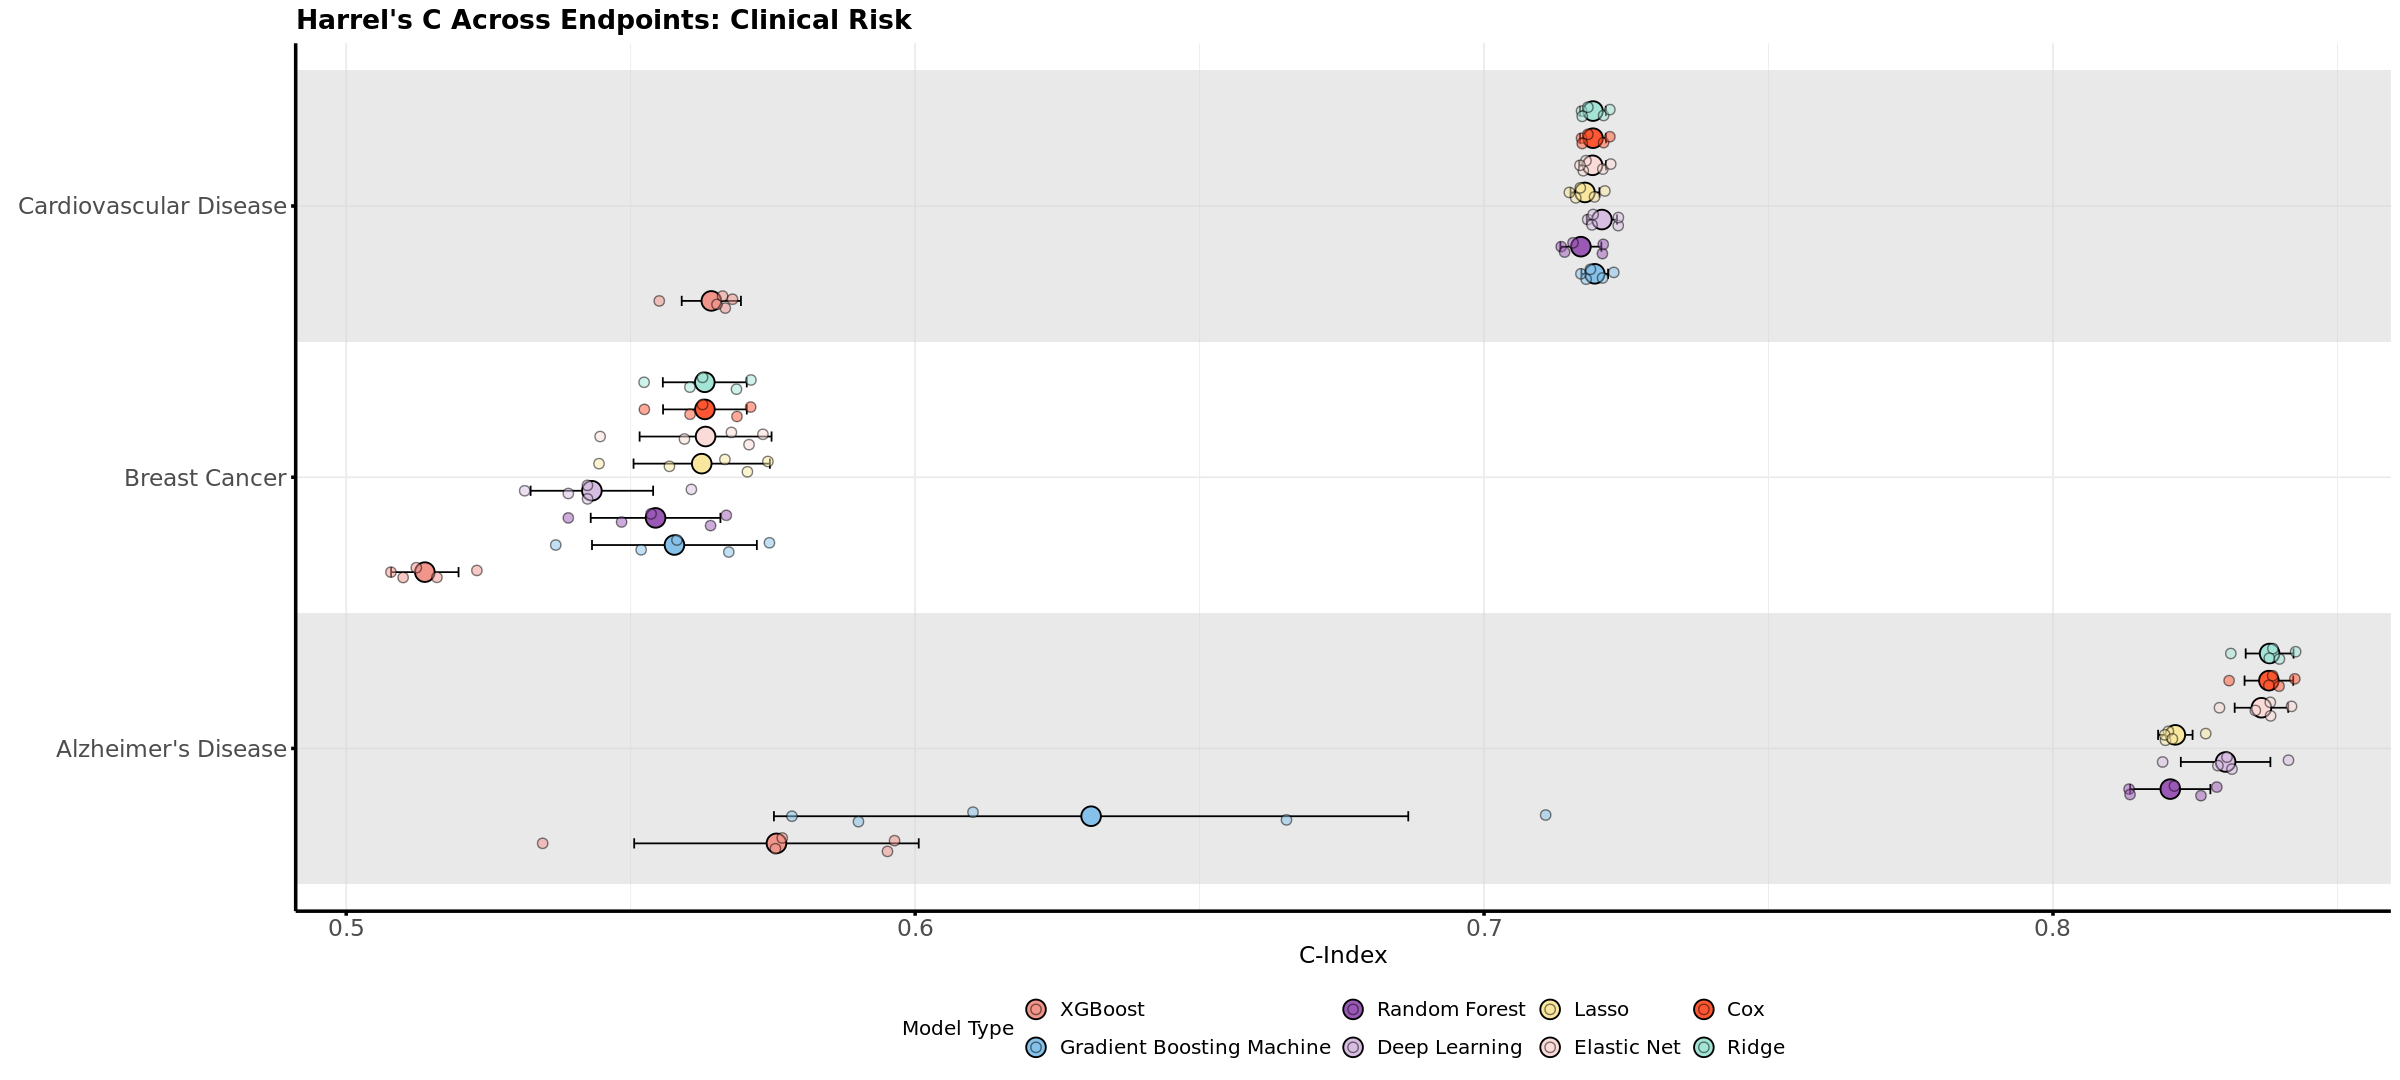

In [46]:
# Model order from "clinicalrisk" only
model_order_df <- results_with_timings %>%
  filter(combo_name == "Clinical Risk") %>%
  group_by(model_type) %>%
  summarise(overall_mean_c_index = mean(c_index_test, na.rm = TRUE)) %>%
  arrange(overall_mean_c_index)

model_order <- model_order_df$model_type

# Define all unique combos
unique_combos <- unique(results_with_timings$combo_name)

# Loop over each combo
for (curr_combo in unique_combos) { 
  print(curr_combo)
  #if (curr_combo != 'Clinical Risk') {next}  
  # Filter data for the current combo
  plot_df <- results_with_timings %>%
    filter(combo_name == curr_combo)
  
  # Summarize performance metrics
  summary_df <- plot_df %>%
    group_by(endpoint, model_type) %>%
    summarise(
      mean_c_index = mean(c_index_test, na.rm = TRUE),
      sd_c_index   = sd(c_index_test, na.rm = TRUE),
      .groups      = "drop"
    )

  # Apply the model order based on "clinicalrisk"
  plot_df$model_type   <- factor(plot_df$model_type,   levels = model_order)
  summary_df$model_type <- factor(summary_df$model_type, levels = model_order)

  # Generate background stripes
  background_data <- data.frame(
    ymin = seq(0.5, length(unique(summary_df$endpoint)) - 0.5, 2),
    ymax = seq(1.5, length(unique(summary_df$endpoint)) + 0.5, 2),
    xmin = -Inf,
    xmax = Inf
  )

  # Create the forest plot
  f1a <- ggplot(summary_df, aes(x = mean_c_index, y = endpoint, fill = model_type)) +
    geom_rect(
      data = background_data,
      aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax),
      fill = "lightgray", alpha = 0.5, inherit.aes = FALSE
    ) +
    geom_errorbarh(
      aes(xmin = mean_c_index - sd_c_index, xmax = mean_c_index + sd_c_index),
      height = 0.3, position = position_dodge(width = 0.8)
    ) +
    geom_point(size = 5, shape = 21, stroke = 0.8, position = position_dodge2(width = 0.8)) +
    geom_quasirandom(
      data = plot_df,
      aes(x = c_index_test, y = endpoint, fill = model_type),
      dodge.width = 0.8, size = 2.5, shape = 21, alpha = 0.5, stroke = 0.6,
      position = position_dodge2(width = 0.8)
    ) +
    scale_fill_manual(values = model_colors) +
    labs(
      title = paste("Harrel's C Across Endpoints:", curr_combo),
      x     = "C-Index",
      y     = NULL,
      fill  = "Model Type"
    ) +
    theme_minimal() +
    theme(
      legend.position = "bottom",
      legend.title    = element_text(size = 12),
      legend.text     = element_text(size = 12),
      axis.line       = element_line(linewidth = 1),
      axis.ticks      = element_line(linewidth = 1),
      axis.text       = element_text(size = 14),
      axis.title.x    = element_text(size = 14),
      axis.title.y    = element_text(size = 14),
      plot.title      = element_text(size = 16, face = "bold")
    )

  print(f1a)

  # Sanitize `curr_combo` for safe filenames
  safe_combo <- gsub("[^A-Za-z0-9]", "_", curr_combo)
  
  # Save the plot to a file
  out_name <- paste0("f1a_", safe_combo, ".svg")
  ggsave(
     filename = out_name,  
     plot = f1a,
     width = 11, height = 12,
     dpi = 1000,
     bg = "transparent"
   )
   message(paste("Saved:", out_name))

  
   uplcmd <- paste0("dx upload \"", out_name, "\" --path Benchmarking/Plots/", out_name)
   system(uplcmd)
   message(paste("Uploaded:", out_name))
}

## 3.2 relative performance

### 3.2.2 combined endpoints

Warning message in geom_quasirandom(data = plot_df, aes(x = delta_c_cox, y = endpoint, :
“Ignoring unknown parameters: `position`”
Orientation inferred to be along y-axis; override with
`position_quasirandom(orientation = 'x')`
Orientation inferred to be along y-axis; override with
`position_quasirandom(orientation = 'x')`
Saved and uploaded: f1b_Clinical_Risk.svg



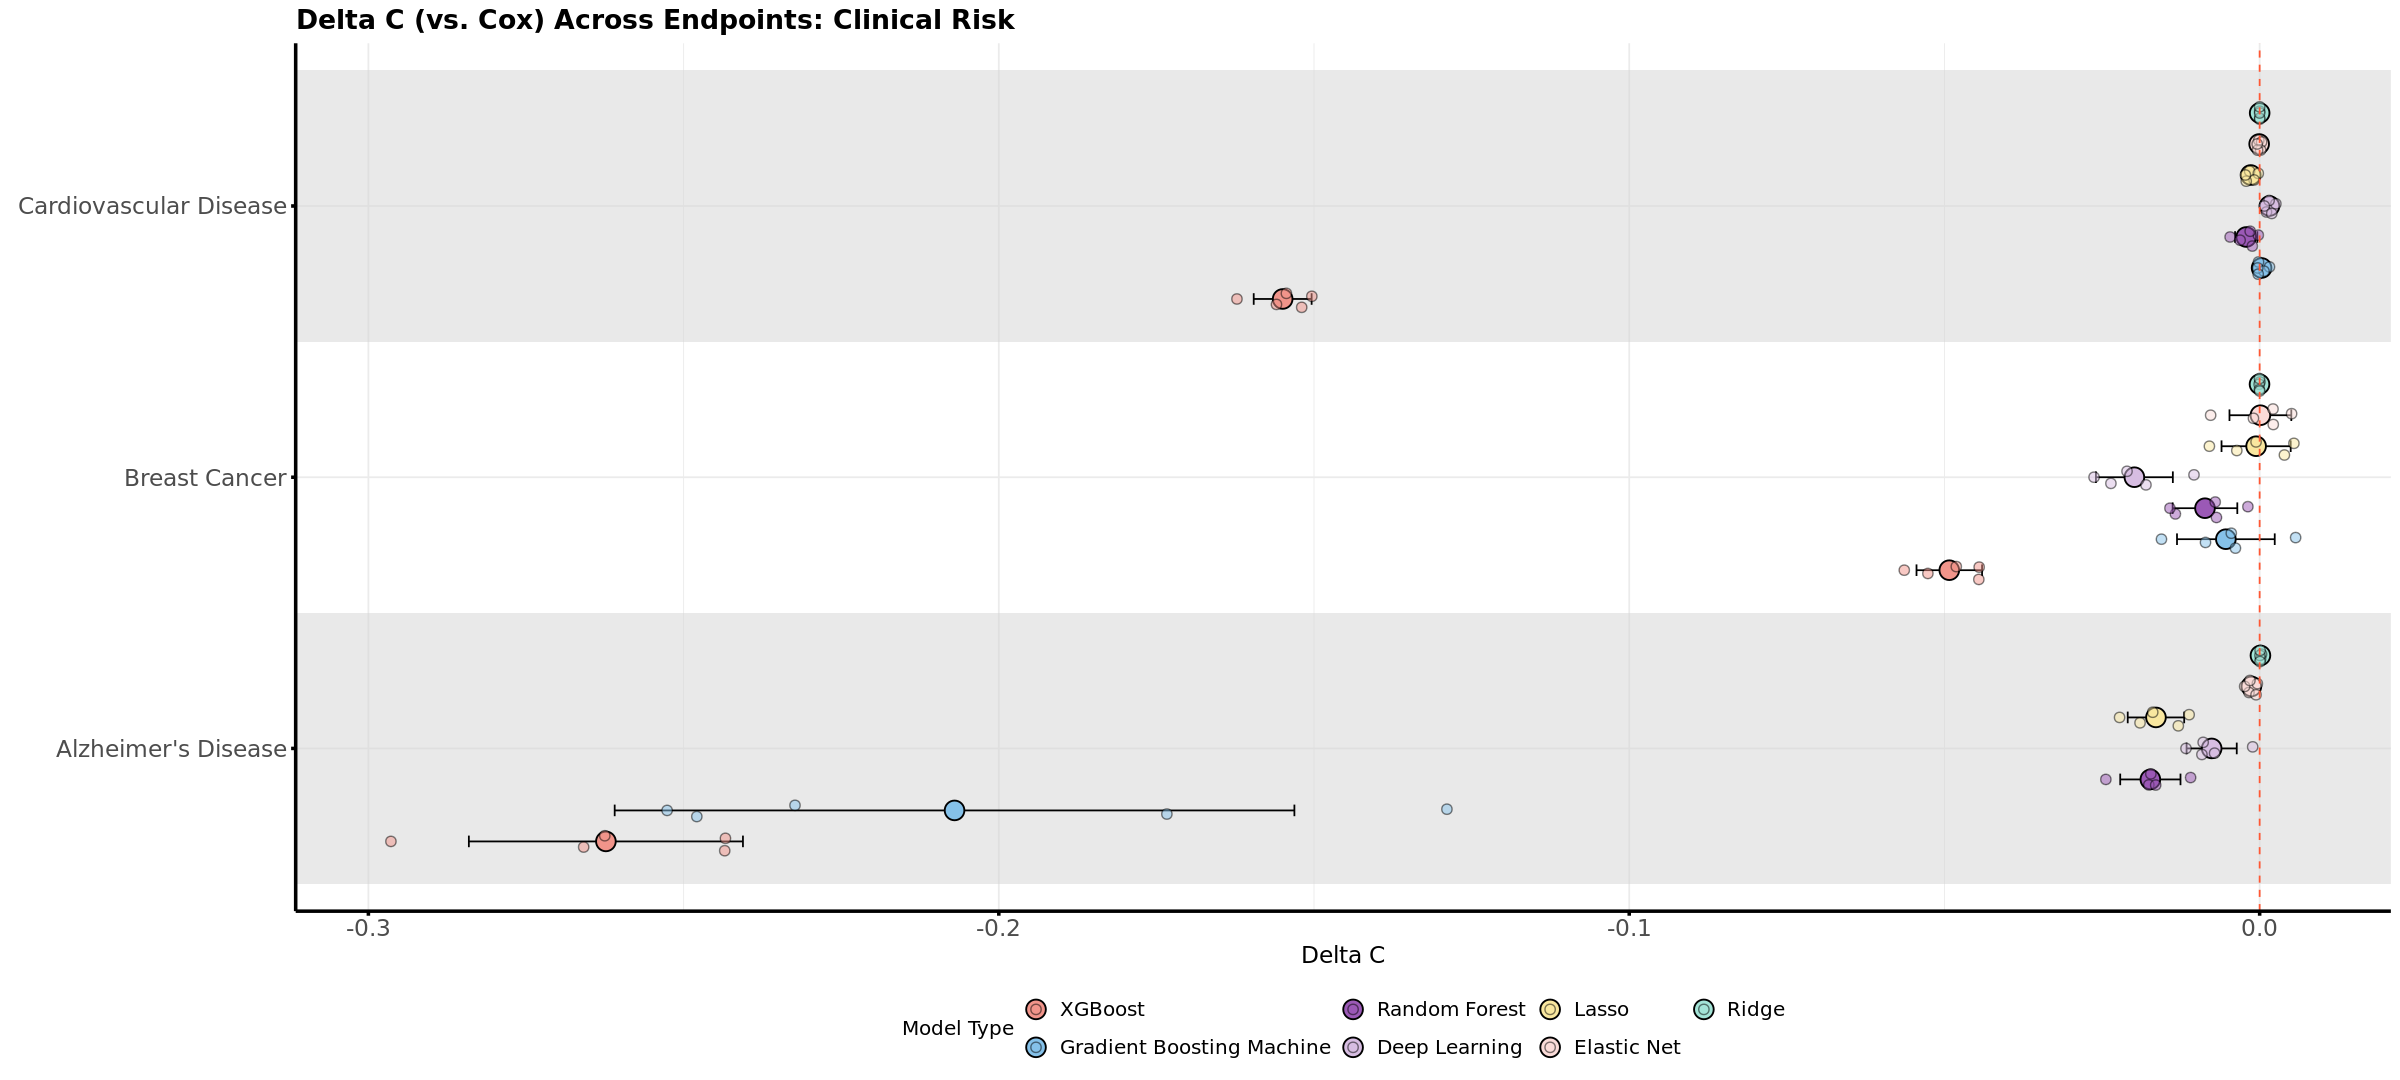

In [50]:
# 1) Grab all combos you want to iterate over
unique_combos <- unique(results_with_timings$combo_name)

# 2) Loop over each combo
for (curr_combo in unique_combos) {
  #if (curr_combo != 'Clinical Risk') {next}  
  # -- Step 1: Filter and compute delta_c_cox for the *current* combo --
  plot_df <- results_with_timings %>%
    filter(combo_name == curr_combo, model_type != "Cox") %>%
    left_join(
      results_with_timings %>%
        filter(combo_name == curr_combo, model_type == "Cox") %>%
        select(cv_split, endpoint, combo_name, cox_c_index = c_index_test),
      by = c("cv_split", "endpoint", "combo_name")
    ) %>%
    mutate(delta_c_cox = c_index_test - cox_c_index)
  
  # -- Step 2: Summarize delta_c_cox by endpoint & model_type --
  summary_df <- plot_df %>%
    group_by(endpoint, model_type) %>%
    summarise(
      mean_delta_c = mean(delta_c_cox, na.rm = TRUE),
      sd_delta_c   = sd(delta_c_cox, na.rm = TRUE),
      .groups      = "drop"
    )
  
  # -- Use the model ordering from "clinicalrisk" for both data frames --
  plot_df$model_type    <- factor(plot_df$model_type, levels = model_order)
  summary_df$model_type <- factor(summary_df$model_type, levels = model_order)
  
  # -- Step 4: Background stripes --
  background_data <- data.frame(
    ymin = seq(0.5, length(unique(summary_df$endpoint)) - 0.5, 2),
    ymax = seq(1.5, length(unique(summary_df$endpoint)) + 0.5, 2),
    xmin = -Inf,
    xmax = Inf
  )
  
  # -- Step 5: Build the forest plot --
  f1b <- ggplot(summary_df, aes(x = mean_delta_c, y = endpoint, fill = model_type)) +
    geom_rect(
      data = background_data,
      aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax),
      fill = "lightgray", alpha = 0.5,
      inherit.aes = FALSE
    ) +
    geom_errorbarh(
      aes(xmin = mean_delta_c - sd_delta_c, xmax = mean_delta_c + sd_delta_c),
      height = 0.3,
      position = position_dodge(width = 0.8)
    ) +
    geom_point(
      size = 5, shape = 21, stroke = 0.8,
      position = position_dodge2(width = 0.8)
    ) +
    geom_quasirandom(
      data = plot_df,
      aes(x = delta_c_cox, y = endpoint, fill = model_type),
      dodge.width = 0.8, size = 2.5, shape = 21,
      alpha = 0.5, stroke = 0.6,
      position = position_dodge2(width = 0.8)
    ) +
    scale_fill_manual(values = model_colors) +
    geom_vline(xintercept = 0, linetype = "dashed", color = "#FF5733") +
    labs(
      title = paste("Delta C (vs. Cox) Across Endpoints:", curr_combo),
      x     = "Delta C",
      y     = NULL,
      fill  = "Model Type"
    ) +
    theme_minimal() +
    theme(
      legend.position = "bottom",
      legend.title    = element_text(size = 12),
      legend.text     = element_text(size = 12),
      axis.line       = element_line(linewidth = 1),
      axis.ticks      = element_line(linewidth = 1),
      axis.text       = element_text(size = 14),
      axis.title.x    = element_text(size = 14),
      axis.title.y    = element_text(size = 14),
      plot.title      = element_text(size = 16, face = "bold")
    )
  
  print(f1b)
  
  # -- Step 6: save
  safe_combo <- gsub("[^A-Za-z0-9]", "_", curr_combo)
  
  out_name <- paste0("f1b_", safe_combo, ".svg")
  ggsave(out_name, plot = f1b, width = 12, height = 12, dpi = 1000, bg = "transparent")
  
  uplcmd <- paste0("dx upload \"", out_name, "\" --path Benchmarking/Plots/", out_name)
  system(uplcmd)
  
  message(paste("Saved and uploaded:", out_name))
}

### 3.2.3 per predictor matrix

#### 3.2.3.1 Ridgeline

In [82]:
#data prep

rank_df <- results_with_timings %>%
  group_by(endpoint, combo_name, cv_split) %>%
  arrange(desc(c_index_test)) %>%
  mutate(rank = row_number()) %>%
  ungroup()


model_order_df <- rank_df %>%
  filter(combo_name == "Clinical Risk") %>%
  group_by(model_type) %>%
  summarise(overall_mean_c_index = mean(c_index_test, na.rm = TRUE)) %>%
  arrange(overall_mean_c_index)

model_order_levels <- model_order_df$model_type


rank_df <- rank_df %>%
  mutate(model_type = factor(model_type, levels = model_order_levels))

In [91]:
background_data <- data.frame(
  ymin = seq(0.5, length(unique(rank_df$endpoint)) - 0.5, 2),
  ymax = seq(1.5, length(unique(rank_df$endpoint)) + 0.5, 2),
  xmin = -Inf,
  xmax = Inf
)

options(repr.plot.width = 8, repr.plot.height = 12)

plot_list <- list()

combo_names <- unique(rank_df$combo_name)

for (i in seq_along(combo_names)) {
  
  combo <- combo_names[i]
  
  subset_rank <- rank_df %>% filter(combo_name == combo)
  
  # Create the plot
  p <- ggplot(subset_rank, aes(x = rank, y = model_type)) +
    # Ridgeline layer
    geom_density_ridges(
      aes(fill = model_type),
      color          = "black",
      alpha          = 0.4,
      scale          = 2,
      rel_min_height = 0.01
    ) +
    # Jittered points
    geom_jitter(
      aes(fill = model_type, shape = endpoint),
      color  = "black",
      stroke = 1,
      size   = 3,
      alpha  = 0.8,
      width  = 0.2,
      height = 0.2
    ) +
    # Reverse x so rank=1 is leftmost
    scale_x_reverse(breaks = 1:max(subset_rank$rank)) +
    # Use custom colors and shapes
    scale_fill_manual(values = model_colors) +
    scale_shape_manual(values = shape_values) +
    labs(
      title = combo,
      x     = "Performance Rank",
      y     = if (i == 1) "Model Type" else NULL, 
      fill  = "Model Type",
      shape = "Endpoint"
    ) +
    theme_minimal() +
    theme(
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position  = "none", 
        axis.line        = element_line(linewidth = 1),
        axis.ticks       = element_line(linewidth = 1),
        axis.text.x        = element_text(size = 14),
        axis.title.x     = element_text(size = 14),
        axis.text.y      = if (i == 1) element_text(size = 14) else element_blank(),
        axis.title.y     = element_blank(),
        plot.title       = element_text(size = 16, face = "bold"),
        plot.margin      = margin(t = 5, b = 5, l = ifelse(i == 1, 10, 5), r = 10)
    )
  
  plot_list[[i]] <- p
  
  message(paste("Prepared plot for:", combo))
}



Prepared plot for: Everything

Prepared plot for: PRS & Metabolomics

Prepared plot for: Clinical Risk

Prepared plot for: Past Medical History

Prepared plot for: Age & Sex



Picking joint bandwidth of 0.565

Picking joint bandwidth of 0.616

Picking joint bandwidth of 1.19

Picking joint bandwidth of 0.699

Picking joint bandwidth of 0.871



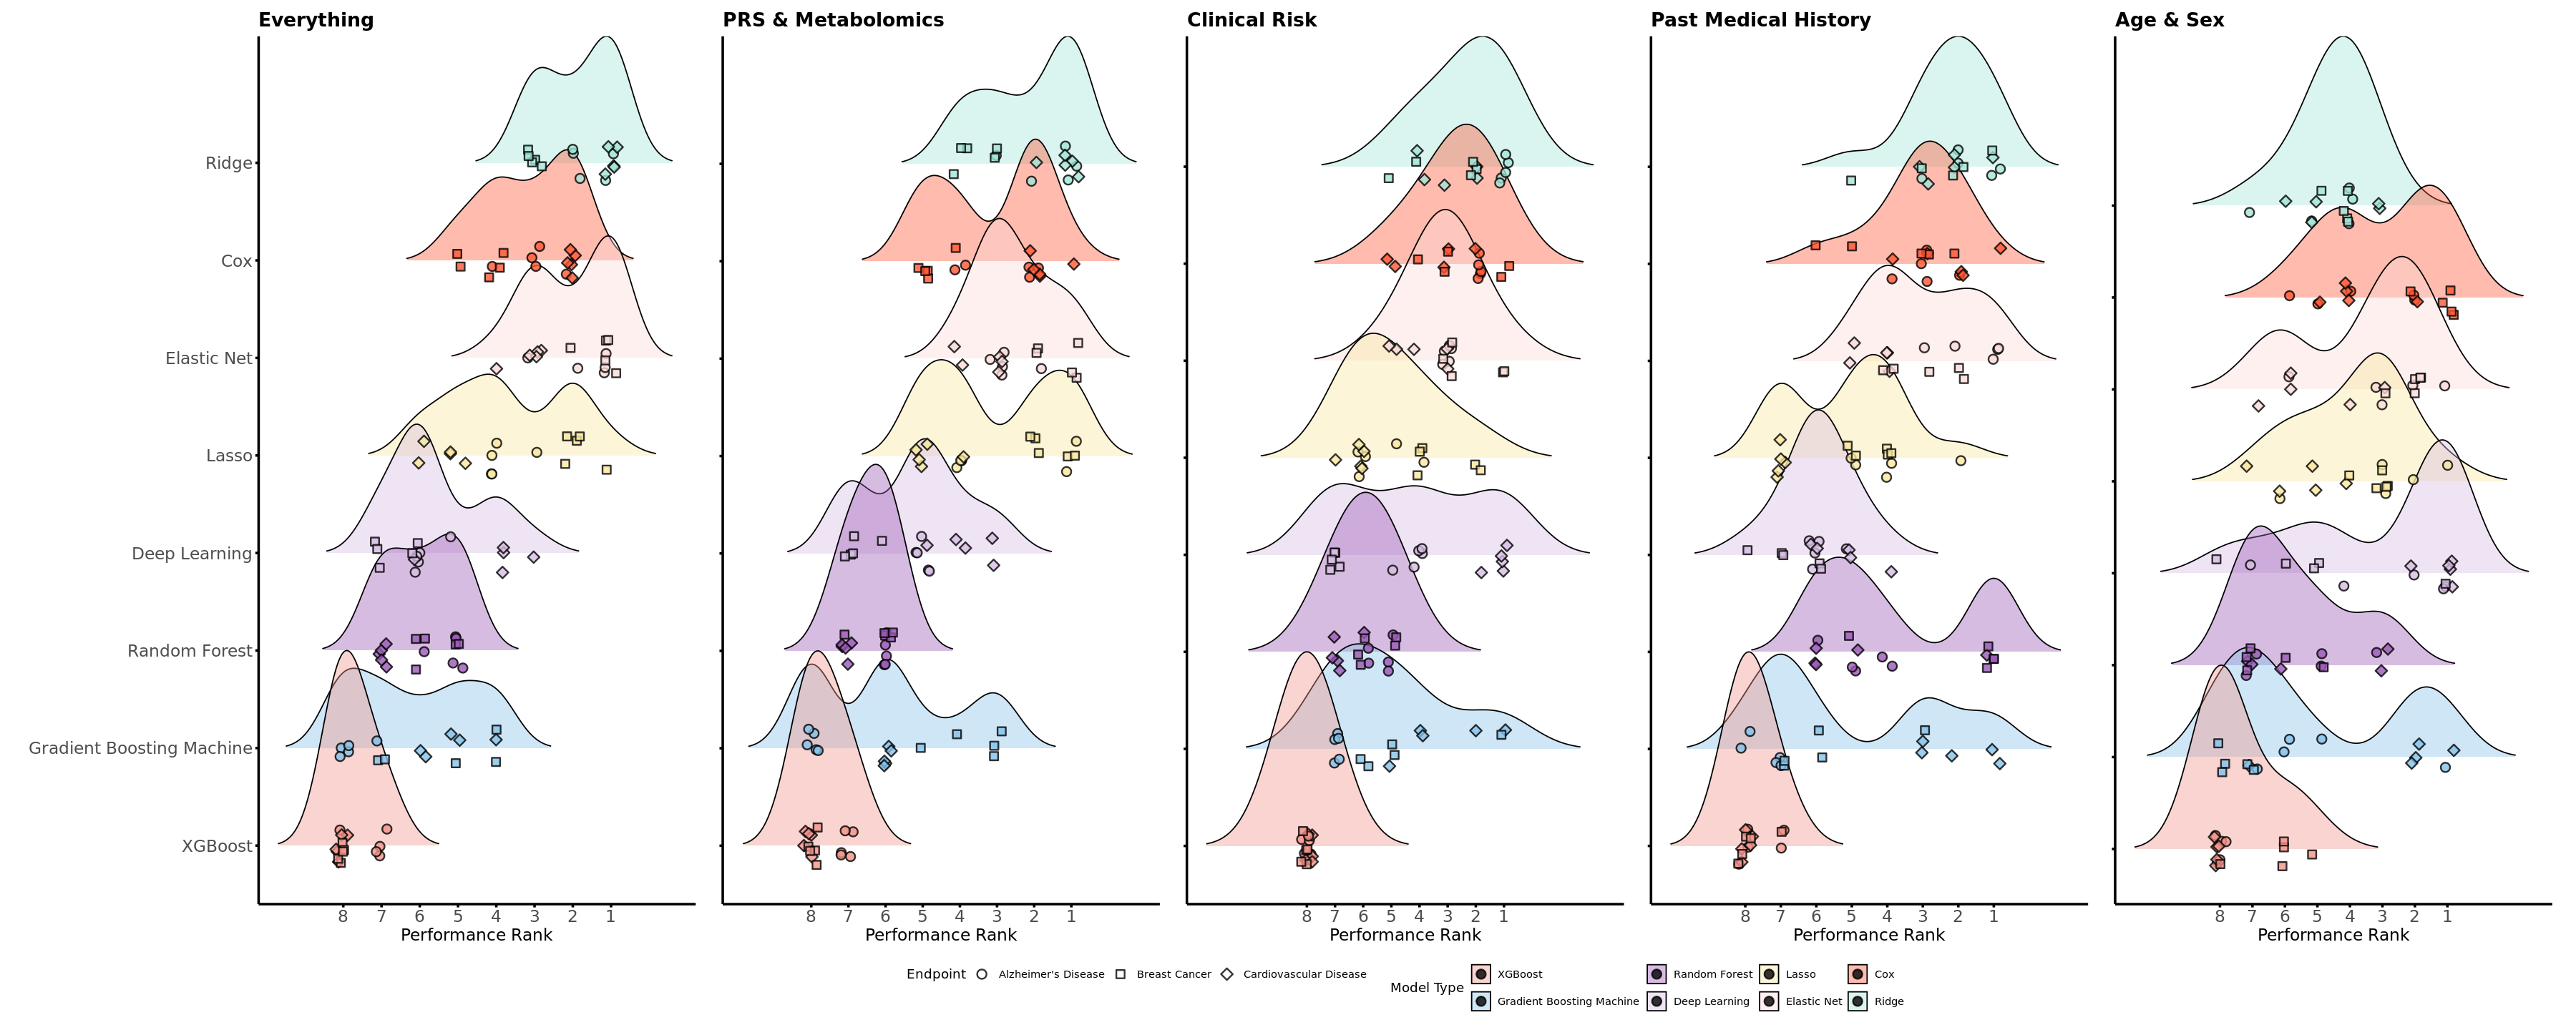

In [93]:
# Adjust the plot dimensions for a single row
options(repr.plot.width = 30, repr.plot.height = 12)

# Combine plots using 'patchwork'
combined_plot <- wrap_plots(plot_list, nrow = 1) +
  plot_layout(guides = "collect") & 
  theme(
    legend.position = "bottom",    
    plot.margin     = margin(t = 5, b = 5, l = 10, r = 10)
  )

# Display the combined plot
print(combined_plot)



In [94]:
ggsave(
  filename = "combined_fig1c.svg",
  plot     = combined_plot,
  width    = 30,   
  height   = 12,
  dpi      = 1000,
  bg       = "transparent"
)

upload_combined_path <- "Benchmarking/Plots/combined_fig1c.svg"
uplcmd_combined <- paste("dx upload combined_fig1c.svg --path", upload_combined_path)
system(uplcmd_combined)

message("Saved and uploaded: combined_fig1c.svg")

Picking joint bandwidth of 0.565

Picking joint bandwidth of 0.616

Picking joint bandwidth of 1.19

Picking joint bandwidth of 0.699

Picking joint bandwidth of 0.871

Saved and uploaded: combined_fig1c.svg



## 3.3 Timing plots

### 3.3.1 Reformatting DF

In [99]:
timings_df <- final_timings_df

timings_df <- timings_df %>%
  mutate(model_type = recode(
    model_type,
    "Cox"       = "Cox",
    "DL"        = "Deep Learning",
    "EN"        = "Elastic Net",
    "Lasso"     = "Lasso",
    "lightGBM"  = "Gradient Boosting Machine",
    "RangerRF"  = "Random Forest",
    "Ridge"     = "Ridge",
    "XGB"       = "XGBoost"
  ))

In [100]:
# Ensure 'once_time' is positive
timings_df <- timings_df %>%
  filter(once_time > 0) %>%  # Remove non-positive times
  mutate(log_once_time = log10(once_time))

In [101]:
# Remove "_cvsplit" from 'combo_name'
timings_df <- timings_df %>%
  mutate(combo_name = gsub("_cvsplit$", "", combo_name))

In [102]:
timings_df <- timings_df %>%
  mutate(combo_name = recode(
    combo_name,
    "agesex"            = "Age & Sex",
    "clinicalrisk"      = "Clinical Risk",
    "everything"        = "Everything",
    "pmh"               = "Past Medical History",
    "prs_metabolomics"  = "PRS & Metabolomics",
    .default                     = "Other"  # Handle unexpected combo_names
  ))

### 3.3.2 Violins

In [114]:
timings_df <- timings_df %>%
  mutate(endpoint = recode(
    endpoint,
    "CVD" = "Cardiovascular Disease",
    "AD"  = "Alzheimer's Disease",
    "BC"  = "Breast Cancer",
    .default = endpoint 
  ))

In [115]:
# Helper function to generate lighter shades of a base color
generate_shades <- function(base_color, n) {
  proportions <- seq(0.2, 1, length.out = n)
  
  mix_with_white <- function(color, proportion) {
    rgb_color <- col2rgb(color) / 255  # Convert to 0-1 range
    mixed_color <- rgb_color * proportion + 1 * (1 - proportion)  # Mix with white
    rgb(mixed_color[1], mixed_color[2], mixed_color[3])
  }
  
  shades <- sapply(proportions, function(p) mix_with_white(base_color, p))
  
  return(shades)
}


Warning message:
“Removed 48 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message:
“Removed 53 rows containing missing values or values outside the scale range
(`geom_violin()`).”


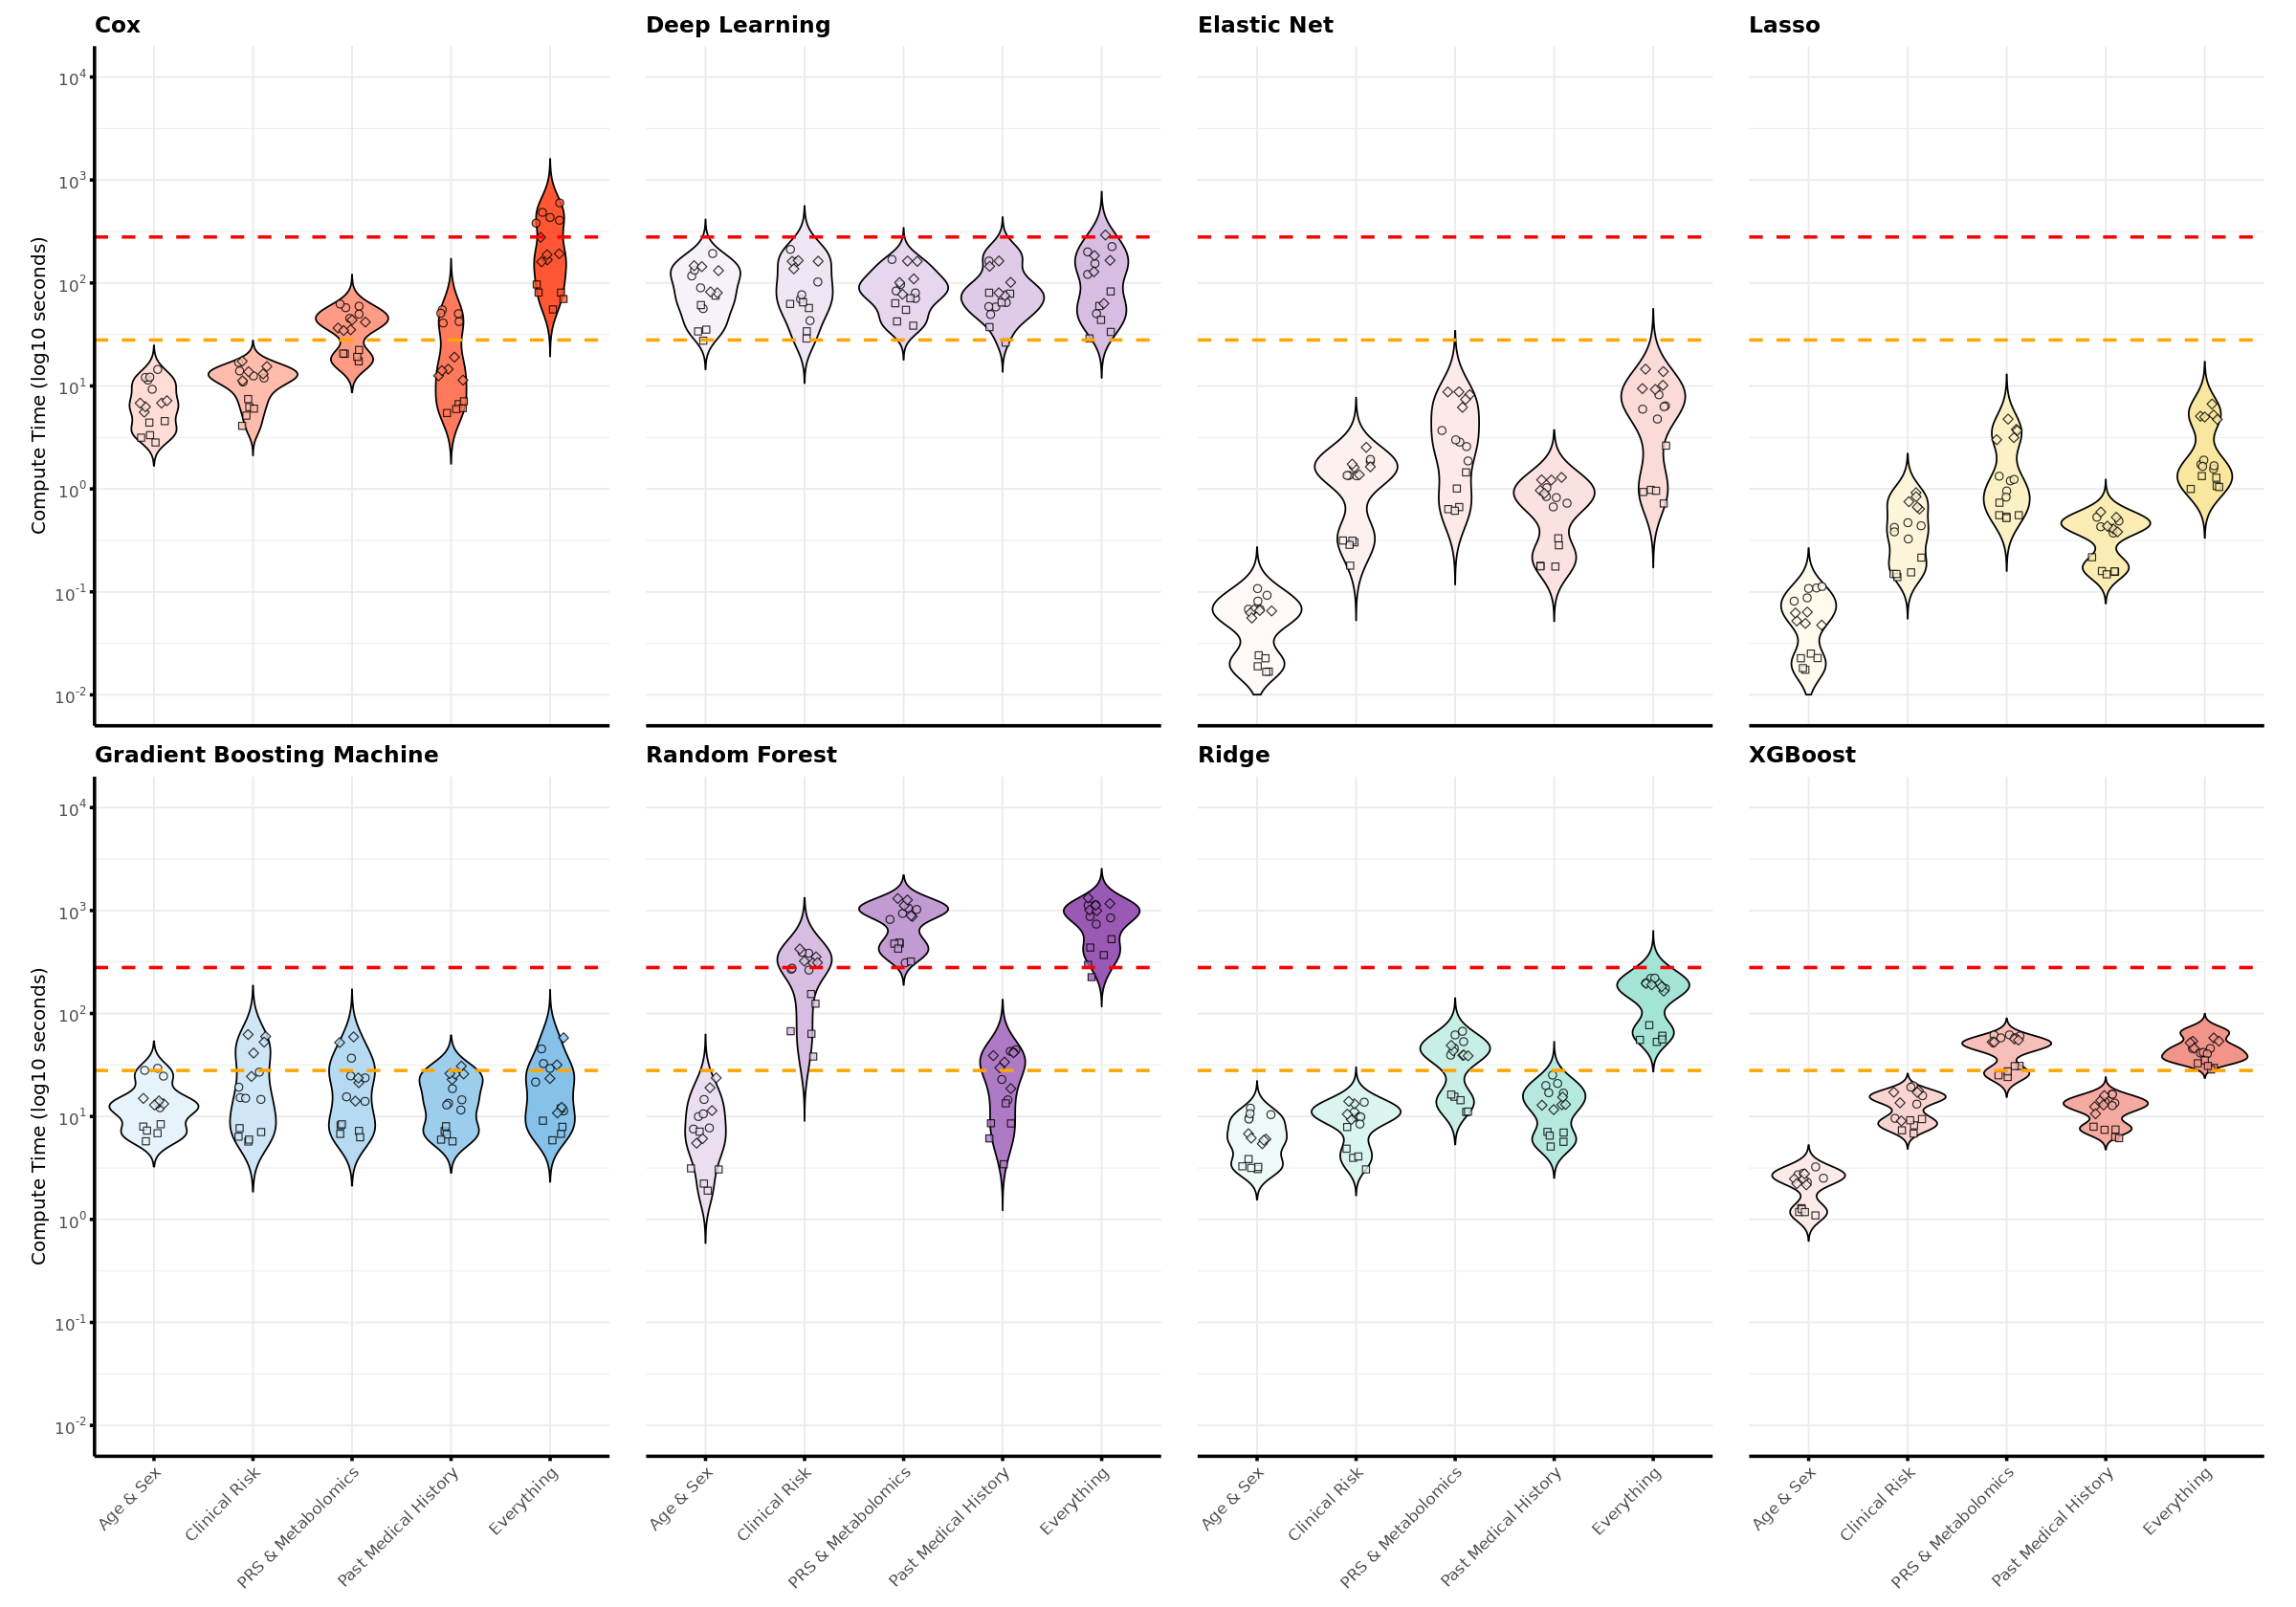

In [116]:
# Adjust the plot dimensions for vertical arrangement
options(repr.plot.width = 20, repr.plot.height = 14)

# Define the desired order of predictor combos
desired_order <- c("Age & Sex", "Clinical Risk", "PRS & Metabolomics", "Past Medical History", "Everything")

# Convert 'combo_name' to a factor with levels in the desired order
timings_df <- timings_df %>%
  mutate(combo_name = factor(combo_name, levels = desired_order)) %>%
  filter(!is.na(combo_name))  # Remove rows with 'combo_name' not in 'desired_order'

# Calculate Global Y-axis Limits on Log Scale
global_min_log_time <- floor(min(timings_df$log_once_time, na.rm = TRUE))
global_max_log_time <- ceiling(max(timings_df$log_once_time, na.rm = TRUE))

# Shapes for endpoints (up to 5 endpoints)
unique_endpoints <- unique(timings_df$endpoint)
shape_values <- c(21, 22, 23, 24, 25)[seq_along(unique_endpoints)]
names(shape_values) <- unique_endpoints

# Define cost_per_hour and calculate corresponding compute time thresholds
cost_per_hour <- 1.2876  # GBP per hour

compute_time_threshold1 <- (0.1 / cost_per_hour) * 3600  # seconds
log_threshold1 <- log10(compute_time_threshold1)       

compute_time_threshold2 <- (0.01 / cost_per_hour) * 3600  # seconds
log_threshold2 <- log10(compute_time_threshold2)       

# Collect plots in a list
model_types <- unique(timings_df$model_type)
num_plots <- length(model_types)
num_rows <- 2
plots_per_row <- ceiling(num_plots / num_rows)
plot_list <- list()

for (i in seq_along(model_types)) {
  
  model <- model_types[i]
  
  # Subset data for the current model_type
  subset_timings <- timings_df %>% filter(model_type == model)
  
  # Generate combo_name shades based on model_type's base color
  base_color <- model_colors[model]
  combo_shades <- generate_shades(base_color, length(desired_order))
  names(combo_shades) <- desired_order
  
  # Create violin plot
  p <- ggplot(subset_timings, aes(x = combo_name, y = log_once_time)) +
    geom_violin(
      aes(fill = combo_name),
      color = "black",
      alpha = 1,
      trim = FALSE
    ) +
    geom_jitter(
      aes(shape = endpoint, fill = combo_name),
      color  = "black",
      stroke = 0.5,
      size   = 2,
      alpha  = 0.8,
      width  = 0.15,
      height = 0.1
    ) +
    geom_hline(
      yintercept = log_threshold1,
      color = "red",
      linetype = "dashed",
      size = 1
    ) +
    geom_hline(
      yintercept = log_threshold2,
      color = "orange",
      linetype = "dashed",
      size = 1
    ) +
    scale_y_continuous(
      limits = c(global_min_log_time, global_max_log_time),
      breaks = seq(global_min_log_time, global_max_log_time, by = 1),
      labels = scales::math_format(10^.x)
    ) +
    scale_fill_manual(values = combo_shades) +
    scale_shape_manual(values = shape_values) +
    labs(
      title = model,
      x = "Predictor Combo",
      y = "Compute Time (log10 seconds)",  # Remove y-axis title
      fill = "Predictor Combo",
      shape = "Endpoint"
    ) +
    theme_minimal(base_size = 12) +
    theme(
      axis.line = element_line(color = "black", size = 1),
      axis.ticks = element_line(color = "black", size = 1),
      legend.position = "none",
      axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
      axis.text.y = element_text(size = 10),
      axis.title.y = element_text(size = 12),
      plot.title = element_text(size = 14, face = "bold", hjust = 0),  # Left-align title
      plot.margin = margin(t = 5, b = 5, l = 10, r = 10)
    )
  
  # Adjust x-axis elements based on row position
  if (i > plots_per_row) {
    p <- p +
      labs(x = NULL) +
      theme(
        axis.title.x    = element_text(size = 12),
        axis.text.x     = element_text(angle = 45, hjust = 1, size = 10),
        axis.ticks.x    = element_line(),
        legend.position = "bottom"
      )
  } else {
    p <- p +
      labs(x = NULL) +
      theme(
        axis.title.x    = element_blank(),
        axis.text.x     = element_blank(),
        axis.ticks.x    = element_blank()
      )
  }
  
  # Remove y-axis components for non-leftmost plots in each row (retain title)
  if (((i - 1) %% plots_per_row) != 0) {
    p <- p + theme(
      axis.line.y   = element_blank(),
      axis.text.y   = element_blank(), 
        axis.title.y = element_blank(),
      axis.ticks.y  = element_blank()
      # Removed plot.title blanking here to retain titles
    )
  }
  
  plot_list[[i]] <- p
}

# Combine plots
library(patchwork)
combined_plot_y <- wrap_plots(plotlist = plot_list, nrow = num_rows) +
  plot_layout(guides = 'collect') &
  theme(
    legend.position = 'none',
    plot.margin     = margin(t = 5, b = 5, l = 10, r = 10)
  )

print(combined_plot_y)

In [117]:
ggsave(
    filename = "f2a.svg",   # Name of the file
    plot = combined_plot_y,                    # The plot object
    width = 20, height = 14,                        # Set width and height
    dpi = 1000,
    bg = "transparent" 
)

uplcmd <- "dx upload f2a.svg --path Benchmarking/Plots/f2a.svg"
system(uplcmd)

Warning message:
“Removed 48 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message:
“Removed 53 rows containing missing values or values outside the scale range
(`geom_violin()`).”


#### 3.3.2.1 Legends


In [120]:
# Create a dummy plot for model_type to extract the legend with black outlines
legend_model <- ggplot(timings_df, aes(x = model_type, fill = model_type)) +
  geom_bar(color = "black") +  # Add black outline to bars
  scale_fill_manual(values = model_colors) +
  theme_void() +  # Remove all non-legend elements
  theme(
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 10),
    legend.position = 'bottom'
  ) +
  guides(fill = guide_legend(title = "Model Type"))


# Create a dummy plot for endpoint shapes to extract the legend with black outlines
legend_endpoint <- ggplot(timings_df, aes(x = endpoint, y = 0, shape = endpoint)) +
  geom_point(color = "black", size = 3) +  # 'color' sets the outline color
  scale_shape_manual(values = shape_values) +
  theme_void() +  # Remove all non-legend elements
  theme(
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 10),
    legend.position = 'bottom'
  ) +
  guides(
    shape = guide_legend(title = "Endpoint"),
    fill = guide_legend(title = "Endpoint")
  )



In [122]:
# Save the model_type legend with black outlines
ggsave(
  filename = "legend_fig2color.svg",
  plot = legend_model,
  width = 10,        
  height = 3,       
  dpi = 300       
)

# Save the endpoint legend with black outlines
ggsave(
  filename = "legend_fig2shape.svg",
  plot = legend_endpoint,
  width = 10,      
  height = 3,       
  dpi = 300       
)

uplcmd <- "dx upload legend_fig2color.svg --path Benchmarking/Plots/legend_fig2color.svg"
system(uplcmd)

uplcmd <- "dx upload legend_fig2shape.svg --path Benchmarking/Plots/legend_fig2shape.svg"
system(uplcmd)


### 3.3.4 Bump charts

#### 3.3.4.1 generate df

In [10]:
options(repr.plot.width = 10, repr.plot.height = 8)

timings_df <- final_timings_df

# Recode model names for clarity
timings_df <- timings_df %>%
  mutate(model_type = recode(
    model_type,
    "Cox"        = "Cox",
    "DL"         = "Deep Learning",
    "EN"         = "Elastic Net",
    "Lasso"      = "Lasso",
    "lightGBM"   = "Gradient Boosting Machine",
    "RangerRF"   = "Random Forest",
    "Ridge"      = "Ridge",
    "XGB"        = "XGBoost",
    .default     = model_type
  ))

# Recode combo_name and remove unwanted suffixes
timings_df <- timings_df %>%
  mutate(
    combo_name = gsub("_cvsplit$", "", combo_name),
    combo_name = factor(combo_name, levels = c("agesex", "clinicalrisk", "prs_metabolomics", "pmh", "everything"))
  ) %>%
  filter(!is.na(combo_name)) %>%
  mutate(combo_name = recode(
    combo_name,
    "agesex"            = "Age & Sex",
    "clinicalrisk"      = "Clinical Risk",
    "everything"        = "Everything",
    "pmh"               = "Past Medical History",
    "prs_metabolomics"  = "PRS & Metabolomics"
  ))

# Define desired order for combo_name
desired_order <- c("Age & Sex", "Clinical Risk", "PRS & Metabolomics", "Past Medical History", "Everything")
timings_df$combo_name <- factor(timings_df$combo_name, levels = desired_order)

# Calculate average compute time for each model_type and combo_name
avg_df <- timings_df %>%
  group_by(combo_name, model_type) %>%
  summarize(avg_time = mean(once_time, na.rm = TRUE)) %>%
  ungroup()

# Rank model_types based on average time for each combo_name
ranked_df <- avg_df %>%
  group_by(combo_name) %>%
  arrange(avg_time) %>%
  mutate(rank = row_number()) %>%
  ungroup()

# Calculate median compute time for each model_type, combo_name, and endpoint
median_df <- timings_df %>%
  group_by(endpoint, combo_name, model_type) %>%
  summarize(median_time = median(once_time, na.rm = TRUE)) %>%
  ungroup()

# Rank model_types per endpoint and combo_name based on median_time
median_df <- median_df %>%
  group_by(endpoint, combo_name) %>%
  arrange(median_time) %>%
  mutate(rank = row_number()) %>%
  ungroup()

`summarise()` has grouped output by 'combo_name'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'endpoint', 'combo_name'. You can override
using the `.groups` argument.


#### 3.3.4.2 Plot combined over endpoints

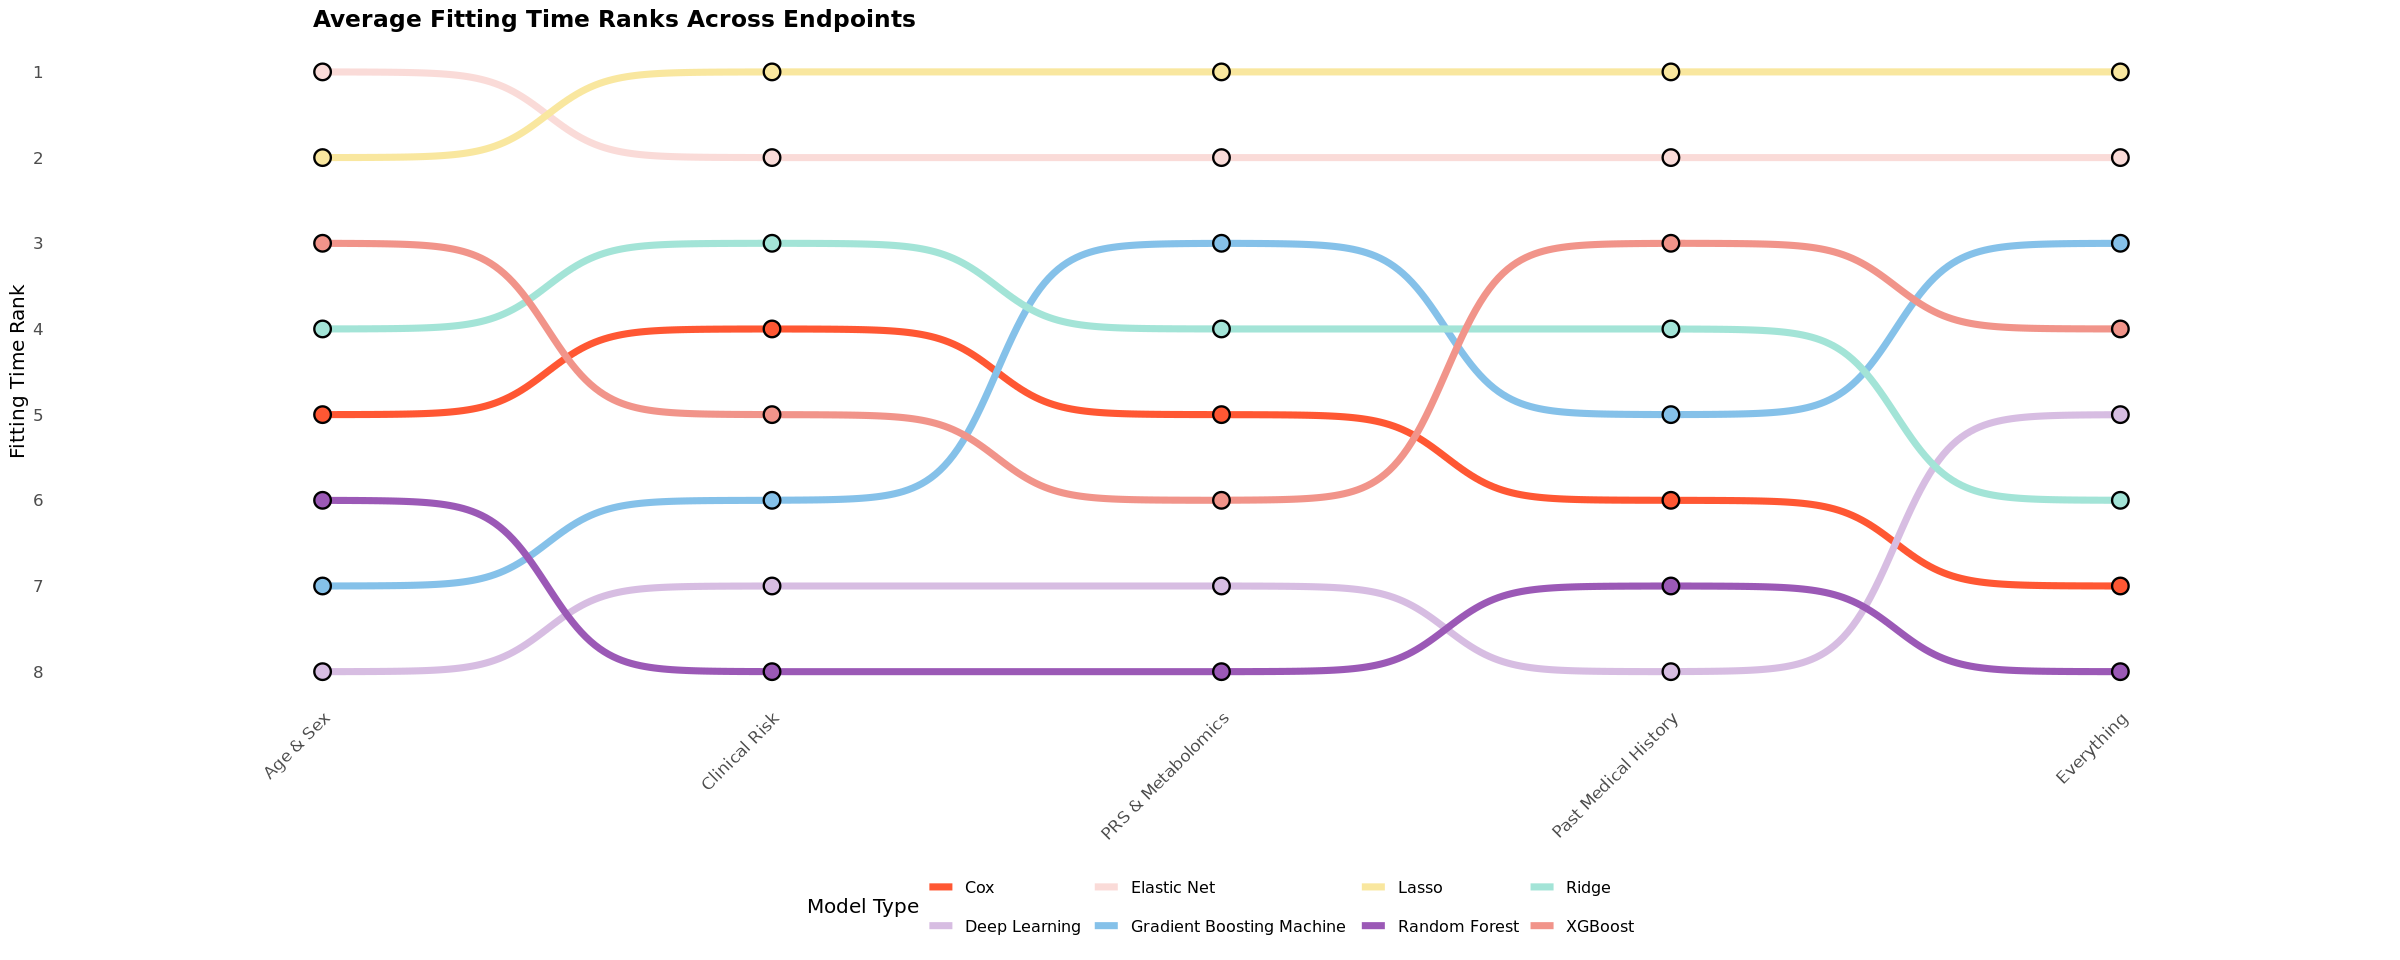

In [127]:
options(repr.plot.width = 20, repr.plot.height = 8)

f2b <- ggplot(ranked_df, aes(x = combo_name, y = rank, group = model_type)) +
  geom_bump(aes(color = model_type), size = 2, smooth = 8) +
  geom_point(shape = 21, aes(fill = model_type), size = 4, stroke = 1, color = "black") +
  scale_y_reverse(breaks = unique(ranked_df$rank)) +
  scale_x_discrete(labels = desired_order) +
  scale_color_manual(values = model_colors, guide = guide_legend(order = 1)) +
  scale_fill_manual(values = model_colors, guide = "none") +
  labs(
    title = "Average Fitting Time Ranks Across Endpoints",
    x = NULL,
    y = "Fitting Time Rank"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    panel.grid.major   = element_blank(),
    panel.grid.minor   = element_blank(),
    axis.text.x        = element_text(size = 10, angle = 45, hjust = 1, vjust = 1),
    axis.title.x       = element_text(size = 12),
    axis.text.y        = element_text(size = 10),
    axis.title.y       = element_text(size = 12),
    plot.title         = element_text(size = 14, face = "bold", hjust = 0.15),
    legend.position    = "bottom"
  ) +
  guides(
    color = guide_legend(
      title = "Model Type",
      override.aes = list(shape = 21),
      order = 1
    )
  )

print(f2b)

In [128]:
ggsave(
    filename = "fig2_b.svg",   
    plot = f2b,                    
    width = 20, height = 8,                        
    dpi = 1000,
    bg = "transparent" 
)

uplcmd <- "dx upload fig2_b.svg --path Benchmarking/Plots/f2b.svg"
system(uplcmd)

## 3.4 Summary plots

### 3.4.1 Heatmap - averaged ranked C across models, matrices and endpoints

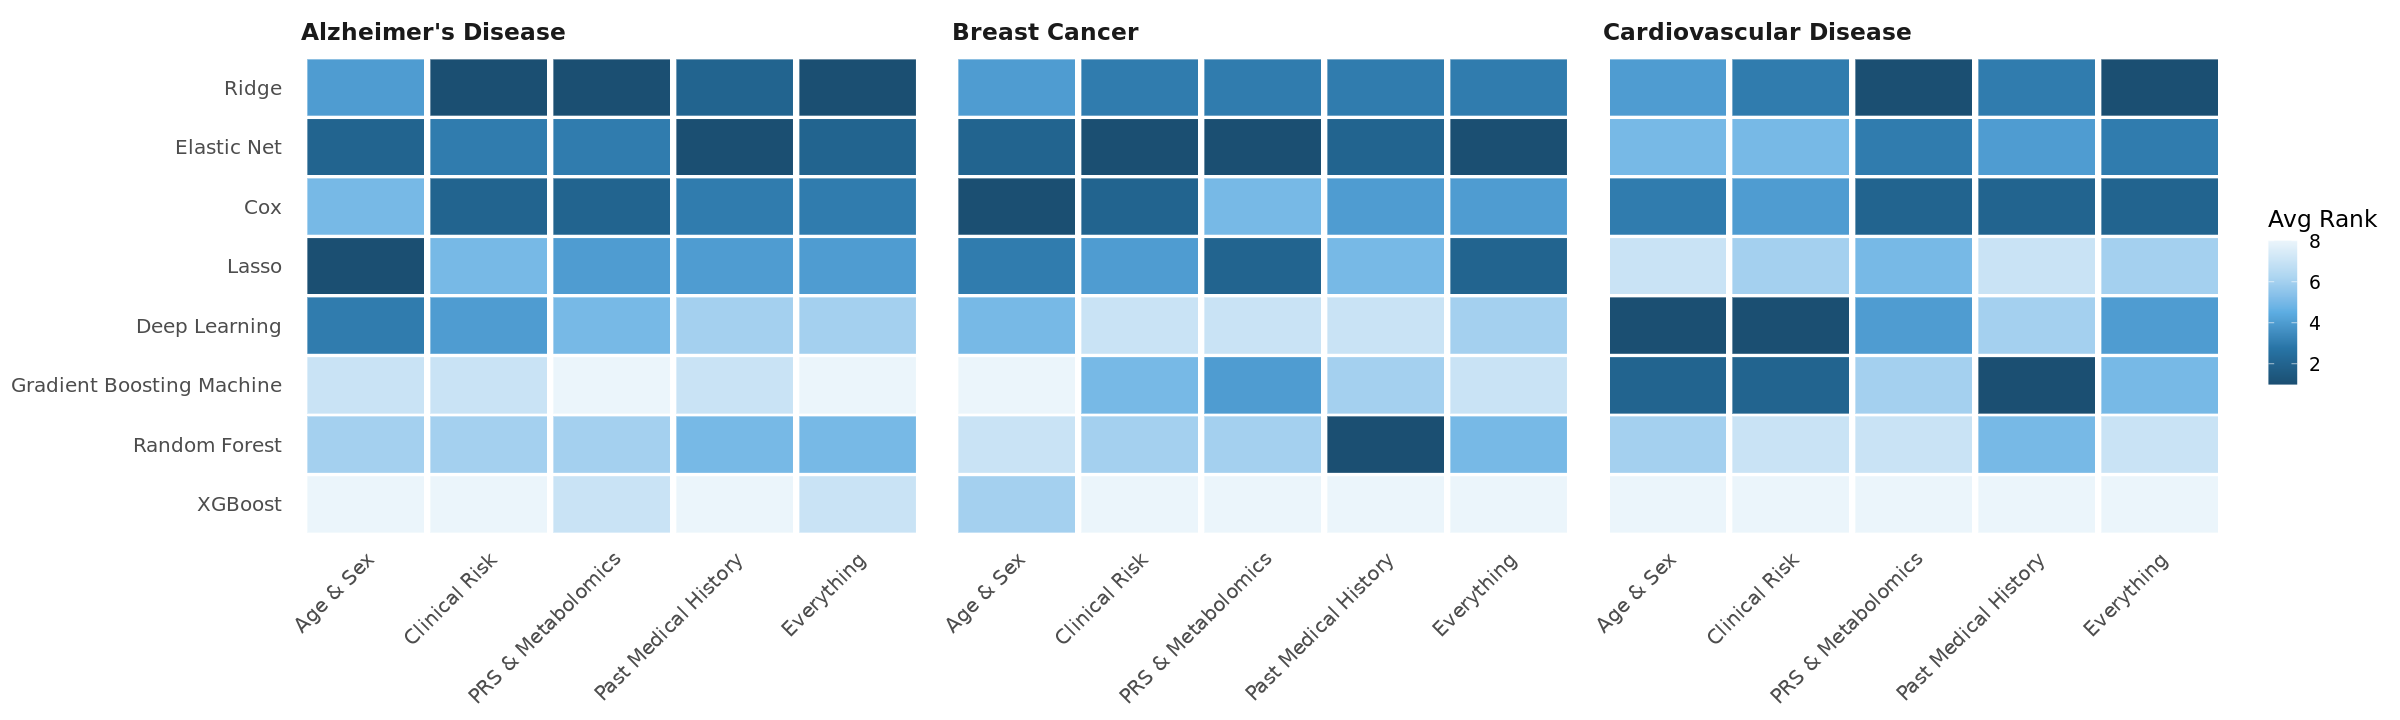

In [23]:
options(repr.plot.width = 20, repr.plot.height = 6)

## 1. Prepare Data and Compute Average Ranks
plot_df <- results_with_timings %>%
  group_by(model_type, endpoint, combo_name) %>%
  summarize(
    c_index_test = mean(c_index_test, na.rm = TRUE),
    once_time    = mean(once_time, na.rm = TRUE),
    .groups = "drop"  
  ) %>%
  filter(once_time > 0) %>%
  mutate(
    log_once_time = log10(once_time)
  )

# Assign ranks based on c_index_test within each endpoint and combo_name
ranked_df <- plot_df %>%
  group_by(endpoint, combo_name) %>%
  mutate(rank_c_index = rank(-c_index_test, ties.method = "first")) %>%
  ungroup()

# Define the desired order for combo_name
desired_order <- c("Age & Sex", "Clinical Risk", "PRS & Metabolomics", "Past Medical History", "Everything")

# Convert combo_name to a factor with the specified order and filter out any NAs
ranked_df <- ranked_df %>%
  mutate(combo_name = factor(combo_name, levels = desired_order)) %>%
  filter(!is.na(combo_name))

# Define shapes 
unique_combos <- unique(ranked_df$combo_name)
shape_values <- c(21, 22, 23, 24, 25)[seq_along(unique_combos)]
names(shape_values) <- unique_combos

# Calculate average rank for each combination of endpoint, model_type, and combo_name
avg_rank_df <- ranked_df %>%
  group_by(endpoint, model_type, combo_name) %>%
  summarize(
    avg_rank = mean(rank_c_index, na.rm = TRUE),
    .groups = "drop"  # Explicitly drop grouping after summarization
  )

## 2. Reorder Models Uniformly Using Global Average Rank Logic

# Compute the global average rank for each model_type across all endpoints and combo_names
cindex_ranks <- avg_rank_df %>%
  group_by(model_type) %>%
  summarize(
    global_avg_rank = mean(avg_rank, na.rm = TRUE),
    .groups = "drop"  # Explicitly drop grouping after summarization
  )

# Arrange model_types based on their global average rank (ascending order)
global_cindex_ranks <- cindex_ranks %>%
  arrange(global_avg_rank)

# Extract the ordered list of model_types
model_order <- global_cindex_ranks %>% pull(model_type)

# Convert model_type to a factor with the specified global order
avg_rank_df <- avg_rank_df %>%
  mutate(model_type = factor(model_type, levels = model_order))

## 3. Create Heatmap Plot
heatmap_plot <- ggplot(avg_rank_df, aes(x = combo_name, y = model_type, fill = avg_rank)) +
  geom_tile(color = "white", width = 0.95, height = 0.95) +
  facet_wrap(~ endpoint) +
  scale_fill_gradientn(
    colors = c("#1B4F72", "#2874A6", "#5DADE2", "#AED6F1", "#EBF5FB"),
    values = c(0, 0.25, 0.5, 0.75, 1),
    na.value = "grey90",
    name = "Avg Rank"
  ) +
  labs(x = NULL, y = NULL) +
  # Invert the y-axis so the best model appears at the top
  scale_y_discrete(limits = rev(levels(avg_rank_df$model_type))) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 12),
    strip.text = element_text(size = 14, face = "bold", hjust = 0),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  )

print(heatmap_plot)

In [32]:
ggsave(
    filename = "fig3a.svg",   
    plot = heatmap_plot,     
    width = 20, height = 6,  
    dpi = 1000,
    bg = "transparent" 
)

uplcmd <- "dx upload fig3a.svg --path Benchmarking/Plots/f3a.svg"
system(uplcmd)

### 3.4.2 Dotplot - combined performance metrics for clinical risk matrix

In [27]:
options(repr.plot.width = 20, repr.plot.height = 9)

#### 3.4.2.1 For 20% metrices

In [28]:
unique_combos <- unique(results_with_timings$combo_name)

for (curr_combo in unique_combos) {
  
  message(paste("Processing Combo:", curr_combo))
  
  results_clinical <- results_with_timings %>% 
    filter(combo_name == curr_combo)
  
  
  #reshape to long 
  results_long <- results_clinical %>%
    select(
      model_type, endpoint, cv_split,
      c_index_test,
      delta_c,
      uno_c,          
      sensitivity_20, 
      specificity_20,
      fpr_20, 
      fnr_20,
      logrank_p_val_20,
      rmst_diff_20,
      once_time
    ) %>%  
    pivot_longer(
      cols = -c(model_type, endpoint, cv_split),
      names_to = "metric",
      values_to = "value"
    )
  
  #recode metirc names
  results_long <- results_long %>%
    mutate(
      metric = case_when(
        metric == "c_index_test" ~ "Harrel's C",
        metric == "delta_c" ~ "Overfitting Bias",
        metric == "uno_c" ~ "Uno's C",  
        metric == "sensitivity_20" ~ "Sensitivity",
        metric == "specificity_20" ~ "Specificity",
        metric == "fpr_20" ~ "False Positive Rate",
        metric == "fnr_20" ~ "False Negative Rate",
        metric == "logrank_p_val_20" ~ "Significance in Logrank Test",
        metric == "rmst_diff_20" ~ "Δ Restricted Mean Survival Time",
        metric == "once_time" ~ "Fitting Time",
        TRUE ~ metric  # Retain original name if no match
      )
    )
  
  # Define metrics where lower values are better (ascending)
  ascending_metrics <- c(
    "Significance in Logrank Test", 
    "False Positive Rate", 
    "False Negative Rate", 
    "Overfitting Bias", 
    "Δ Restricted Mean Survival Time", 
    "Fitting Time"
  )
  
  # 'min' ensures that tied models receive the lowest possible rank
  results_ranked <- results_long %>%
    group_by(cv_split, endpoint, metric) %>%
    mutate(
      initial_rank = if_else(
        metric %in% ascending_metrics,
        rank(value, ties.method = "min"),    # Lower is better
        rank(-value, ties.method = "min")    # Higher is better
      )
    ) %>%
    ungroup()
  
  # Average the initial ranks across cv_splits for each model_type, endpoint, and metric
  avg_rank_df <- results_ranked %>%
    group_by(model_type, endpoint, metric) %>%
    summarize(
      avg_rank = mean(initial_rank, na.rm = TRUE),
      .groups = "drop"  # Explicitly drop grouping after summarization
    )
  
  # Reorder model_type based on Harrel's C average rank
  harrels_c_rank <- avg_rank_df %>%
    filter(metric == "Harrel's C") %>%
    group_by(model_type) %>%
    summarize(
      harrels_c_avg_rank = mean(avg_rank, na.rm = TRUE),
      .groups = "drop"
    )
  
  avg_rank_df <- avg_rank_df %>%
    left_join(harrels_c_rank, by = "model_type") %>%
    mutate(
      model_type = fct_reorder(model_type, harrels_c_avg_rank)
    )
  
  #custom metric oder 
  custom_metric_order <- c(
    "Harrel's C", 
    "Uno's C",
    "Sensitivity", 
    "Specificity", 
    "False Positive Rate", 
    "False Negative Rate", 
    "Significance in Logrank Test", 
    "Δ Restricted Mean Survival Time", 
    "Overfitting Bias",  
    "Fitting Time"       
  )
  
  # Define metrics to be highlighted with background shading
  special_metrics <- data.frame(
    metric = c("Overfitting Bias", "Fitting Time"),
    category = c("lightgrey", "darkgrey")
  ) %>%
    filter(metric %in% existing_metrics)
  
  #per endpoint plot
  unique_endpoints <- unique(avg_rank_df$endpoint)
  plot_list <- list()
  
  for(i in seq_along(unique_endpoints)){
    ep <- unique_endpoints[i]
    
    ep_data <- avg_rank_df %>% filter(endpoint == ep)
    
    ep_special_metrics <- special_metrics
    
    p <- ggplot(ep_data, aes(x = metric, y = model_type)) +
      # Draw background rectangles for specified metrics
      geom_rect(
        data = ep_special_metrics,
        aes(
          xmin = as.numeric(factor(metric, levels = custom_metric_order)) - 0.5,
          xmax = as.numeric(factor(metric, levels = custom_metric_order)) + 0.5,
          ymin = -Inf, 
          ymax = Inf, 
          fill = category
        ),
        inherit.aes = FALSE, 
        alpha = 0.2
      ) +
      # Plot the points representing average ranks
      geom_point(aes(size = avg_rank, color = avg_rank)) +
      # Define color gradient for average ranks using a colored palette
      scale_color_gradientn(
        colors = c("darkred", "#DE2D26", "#FC9272", "#FEE0D2"),  
        values = c(0, 0.4, 0.7, 1), 
        na.value = "grey90",
        name = "Average Rank\n(Lower = Better)"
      ) +
      # Use the fill colors directly from special_metrics
      scale_fill_identity() +
      # Define size scale for average ranks
      scale_size_continuous(
        range = c(3, 10),
        name = "Average Rank\n(Lower = Better)"
      ) +  
      # Invert the y-axis so the best model appears at the top
      scale_y_discrete(limits = rev(levels(ep_data$model_type))) +  
      # Define the order of metrics on the x-axis
      scale_x_discrete(limits = custom_metric_order) +
      # Apply a theme that includes axis lines
      theme_minimal(base_size = 14) +
      labs(
        x = NULL, 
        y = NULL,
        title = ep  # Use endpoint name as the plot title
      ) +
      theme(
        axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
        axis.text.y = if(i == 1) element_text(size = 12) else element_blank(),
        axis.title = element_blank(),
        axis.line = element_line(color = "black", linewidth = 0.5),
        axis.ticks = element_line(color = "black", linewidth = 0.5),
        legend.position = "bottom",
        plot.title = element_text(size = 16, face = "bold", hjust = 0),
        strip.text = element_text(size = 14, face = "bold", hjust = 0),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank()
      )
    
    plot_list[[i]] <- p
  }
  
  # Combine the plots
  n_cols <- min(length(unique_endpoints), 3)
  
  combined_plot <- wrap_plots(plot_list, ncol = n_cols) + 
    plot_layout(guides = "collect") & theme(legend.position = "bottom")
  
  print(combined_plot)
  
  # save
  safe_combo <- gsub("[^A-Za-z0-9]", "_", curr_combo)
  out_name <- paste0("f3b_", safe_combo, ".svg")
  
  ggsave(
    filename = out_name, 
    plot = combined_plot, 
    width = 20, 
    height = 9, 
    units = "in", 
    dpi = 1000, 
    bg = "transparent"
  )

  uplcmd <- paste0("dx upload \"", out_name, "\" --path Benchmarking/Plots/", out_name)
  system(uplcmd)
  
  message(paste("Saved and uploaded:", out_name))
  
}

Processing Combo: Age & Sex



ERROR: [1m[33mError[39m in `pivot_longer()`:[22m
[33m![39m Can't combine `c_index_test` <double> and `logrank_p_val_20` <character>.


#### 3.4.2.2 For 10% metrices

In [ ]:
unique_combos <- unique(results_with_timings$combo_name)

for (curr_combo in unique_combos) {
  
  message(paste("Processing Combo:", curr_combo))
  
  results_clinical <- results_with_timings %>% 
    filter(combo_name == curr_combo)
  
  
  #reshape to long 
  results_long <- results_clinical %>%
    select(
      model_type, endpoint, cv_split,
      c_index_test,
      delta_c,
      uno_c,          
      sensitivity_10, 
      specificity_10,
      fpr_10, 
      fnr_10,
      logrank_p_val_10,
      rmst_diff_10,
      once_time
    ) %>%  
    pivot_longer(
      cols = -c(model_type, endpoint, cv_split),
      names_to = "metric",
      values_to = "value"
    )
  
  #recode metirc names
  results_long <- results_long %>%
    mutate(
      metric = case_when(
        metric == "c_index_test" ~ "Harrel's C",
        metric == "delta_c" ~ "Overfitting Bias",
        metric == "uno_c" ~ "Uno's C",  
        metric == "sensitivity_10" ~ "Sensitivity",
        metric == "specificity_10" ~ "Specificity",
        metric == "fpr_10" ~ "False Positive Rate",
        metric == "fnr_10" ~ "False Negative Rate",
        metric == "logrank_p_val_10" ~ "Significance in Logrank Test",
        metric == "rmst_diff_10" ~ "Δ Restricted Mean Survival Time",
        metric == "once_time" ~ "Fitting Time",
        TRUE ~ metric  # Retain original name if no match
      )
    )
  
  # Define metrics where lower values are better (ascending)
  ascending_metrics <- c(
    "Significance in Logrank Test", 
    "False Positive Rate", 
    "False Negative Rate", 
    "Overfitting Bias", 
    "Δ Restricted Mean Survival Time", 
    "Fitting Time"
  )
  
  # 'min' ensures that tied models receive the lowest possible rank
  results_ranked <- results_long %>%
    group_by(cv_split, endpoint, metric) %>%
    mutate(
      initial_rank = if_else(
        metric %in% ascending_metrics,
        rank(value, ties.method = "min"),    # Lower is better
        rank(-value, ties.method = "min")    # Higher is better
      )
    ) %>%
    ungroup()
  
  # Average the initial ranks across cv_splits for each model_type, endpoint, and metric
  avg_rank_df <- results_ranked %>%
    group_by(model_type, endpoint, metric) %>%
    summarize(
      avg_rank = mean(initial_rank, na.rm = TRUE),
      .groups = "drop"  # Explicitly drop grouping after summarization
    )
  
  # Reorder model_type based on Harrel's C average rank
  harrels_c_rank <- avg_rank_df %>%
    filter(metric == "Harrel's C") %>%
    group_by(model_type) %>%
    summarize(
      harrels_c_avg_rank = mean(avg_rank, na.rm = TRUE),
      .groups = "drop"
    )
  
  avg_rank_df <- avg_rank_df %>%
    left_join(harrels_c_rank, by = "model_type") %>%
    mutate(
      model_type = fct_reorder(model_type, harrels_c_avg_rank)
    )
  
  #custom metric oder 
  custom_metric_order <- c(
    "Harrel's C", 
    "Uno's C",
    "Sensitivity", 
    "Specificity", 
    "False Positive Rate", 
    "False Negative Rate", 
    "Significance in Logrank Test", 
    "Δ Restricted Mean Survival Time", 
    "Overfitting Bias",  
    "Fitting Time"       
  )
  
  # Define metrics to be highlighted with background shading
  special_metrics <- data.frame(
    metric = c("Overfitting Bias", "Fitting Time"),
    category = c("lightgrey", "darkgrey")
  ) %>%
    filter(metric %in% existing_metrics)
  
  #per endpoint plot
  unique_endpoints <- unique(avg_rank_df$endpoint)
  plot_list <- list()
  
  for(i in seq_along(unique_endpoints)){
    ep <- unique_endpoints[i]
    
    ep_data <- avg_rank_df %>% filter(endpoint == ep)
    
    ep_special_metrics <- special_metrics
    
    p <- ggplot(ep_data, aes(x = metric, y = model_type)) +
      # Draw background rectangles for specified metrics
      geom_rect(
        data = ep_special_metrics,
        aes(
          xmin = as.numeric(factor(metric, levels = custom_metric_order)) - 0.5,
          xmax = as.numeric(factor(metric, levels = custom_metric_order)) + 0.5,
          ymin = -Inf, 
          ymax = Inf, 
          fill = category
        ),
        inherit.aes = FALSE, 
        alpha = 0.2
      ) +
      # Plot the points representing average ranks
      geom_point(aes(size = avg_rank, color = avg_rank)) +
      # Define color gradient for average ranks using a colored palette
      scale_color_gradientn(
        colors = c("darkred", "#DE2D26", "#FC9272", "#FEE0D2"),  
        values = c(0, 0.4, 0.7, 1), 
        na.value = "grey90",
        name = "Average Rank\n(Lower = Better)"
      ) +
      # Use the fill colors directly from special_metrics
      scale_fill_identity() +
      # Define size scale for average ranks
      scale_size_continuous(
        range = c(3, 10),
        name = "Average Rank\n(Lower = Better)"
      ) +  
      # Invert the y-axis so the best model appears at the top
      scale_y_discrete(limits = rev(levels(ep_data$model_type))) +  
      # Define the order of metrics on the x-axis
      scale_x_discrete(limits = custom_metric_order) +
      # Apply a theme that includes axis lines
      theme_minimal(base_size = 14) +
      labs(
        x = NULL, 
        y = NULL,
        title = ep  # Use endpoint name as the plot title
      ) +
      theme(
        axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
        axis.text.y = if(i == 1) element_text(size = 12) else element_blank(),
        axis.title = element_blank(),
        axis.line = element_line(color = "black", linewidth = 0.5),
        axis.ticks = element_line(color = "black", linewidth = 0.5),
        legend.position = "bottom",
        plot.title = element_text(size = 16, face = "bold", hjust = 0),
        strip.text = element_text(size = 14, face = "bold", hjust = 0),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank()
      )
    
    plot_list[[i]] <- p
  }
  
  # Combine the plots
  n_cols <- min(length(unique_endpoints), 3)
  
  combined_plot <- wrap_plots(plot_list, ncol = n_cols) + 
    plot_layout(guides = "collect") & theme(legend.position = "bottom")
  
  print(combined_plot)
  
  # save
  safe_combo <- gsub("[^A-Za-z0-9]", "_", curr_combo)
  out_name <- paste0("f3b_10percent", safe_combo, ".svg")
  
  ggsave(
    filename = out_name, 
    plot = combined_plot, 
    width = 20, 
    height = 9, 
    units = "in", 
    dpi = 1000, 
    bg = "transparent"
  )

  uplcmd <- paste0("dx upload \"", out_name, "\" --path Benchmarking/Plots/", out_name)
  system(uplcmd)
  
  message(paste("Saved and uploaded:", out_name))
  
}

Processing Combo: Age & Sex

Saved and uploaded: f3b_10percentAge___Sex.svg

Processing Combo: Clinical Risk

Saved and uploaded: f3b_10percentClinical_Risk.svg

Processing Combo: Everything



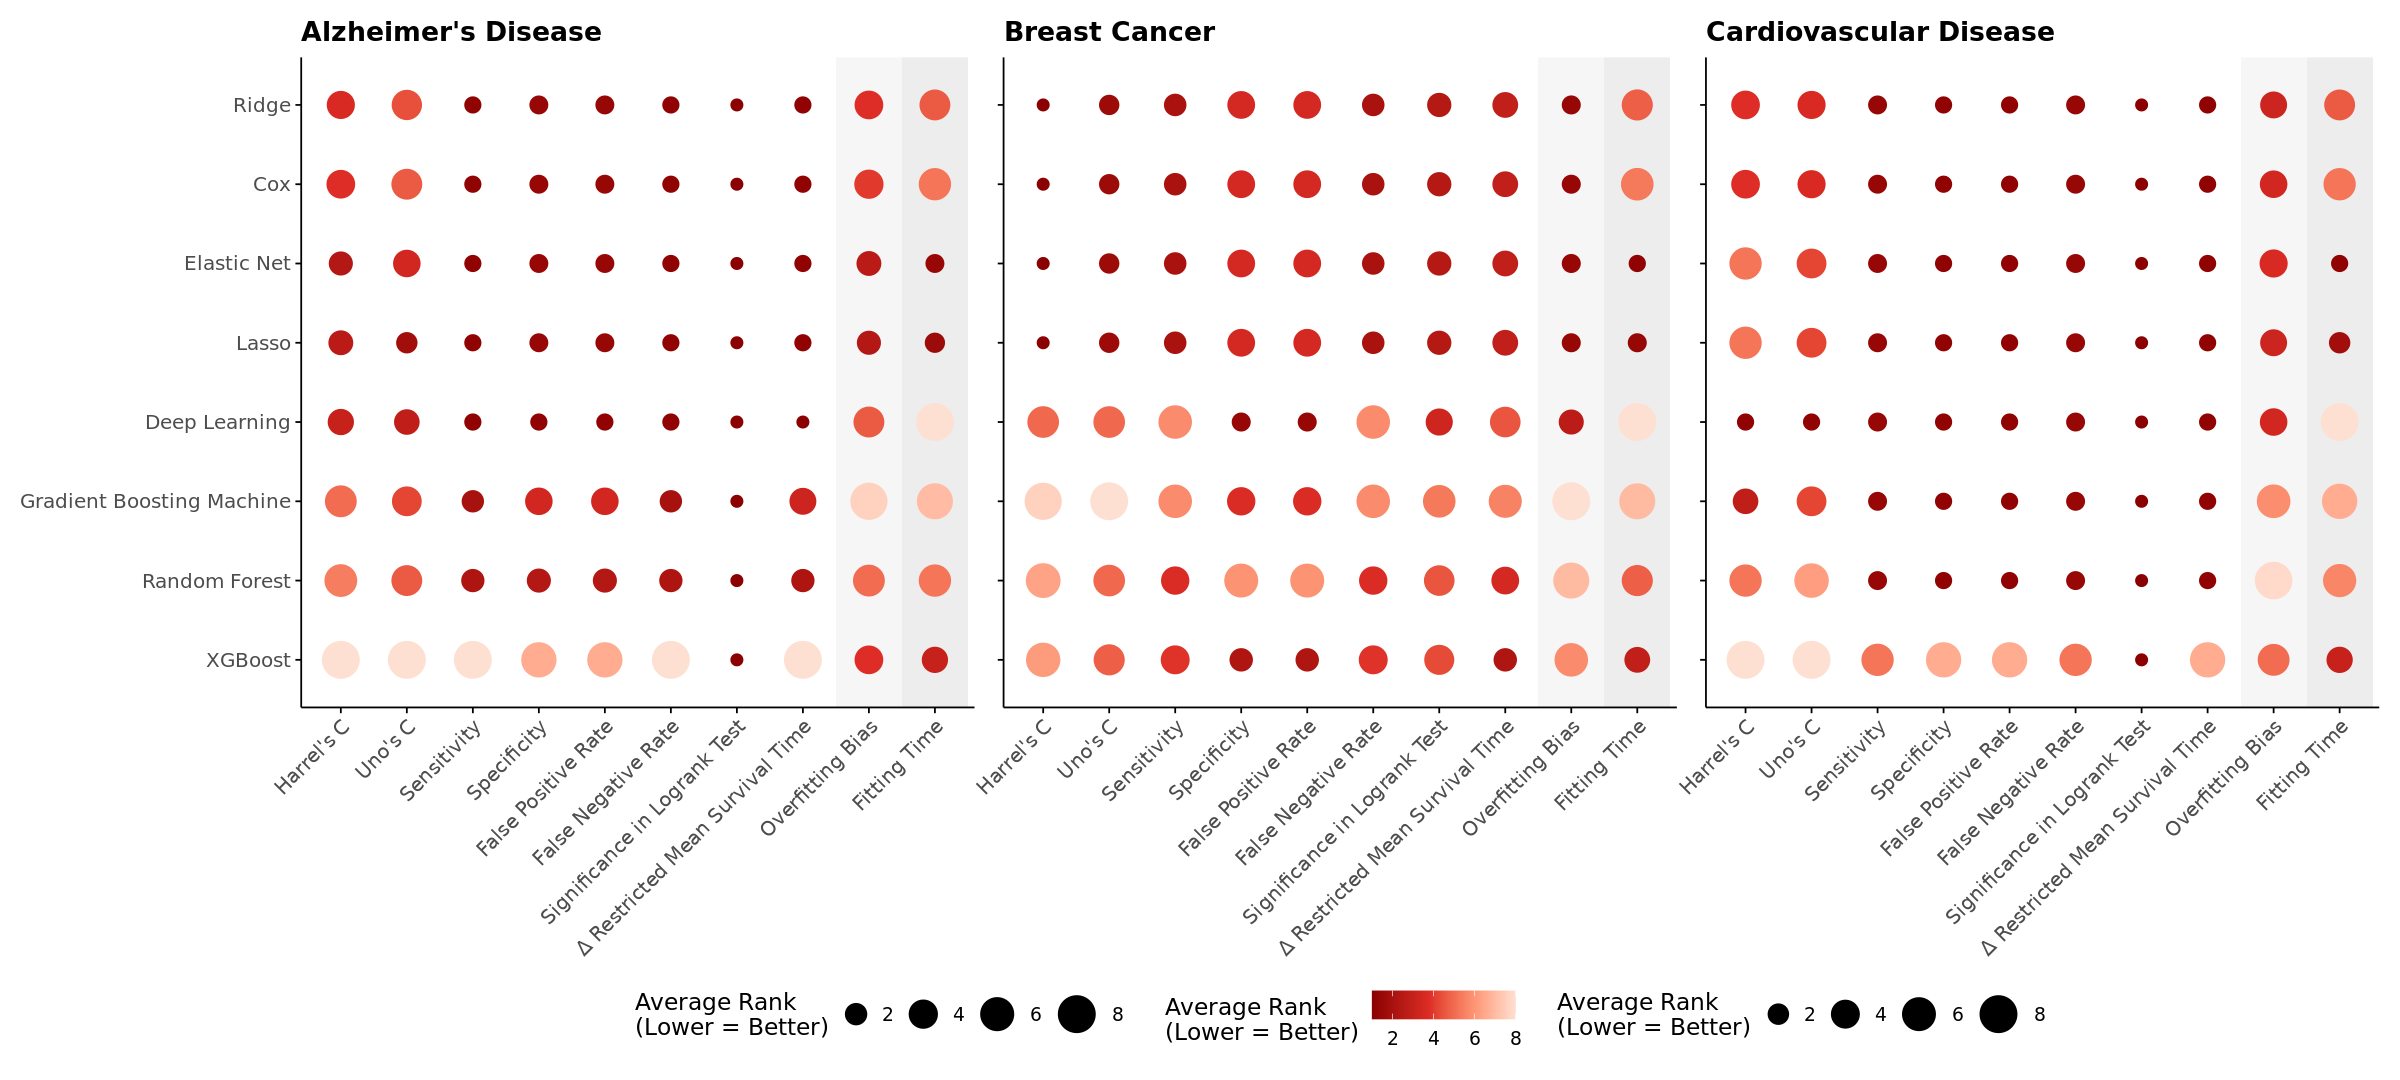

Saved and uploaded: f3b_10percentEverything.svg

Processing Combo: Past Medical History



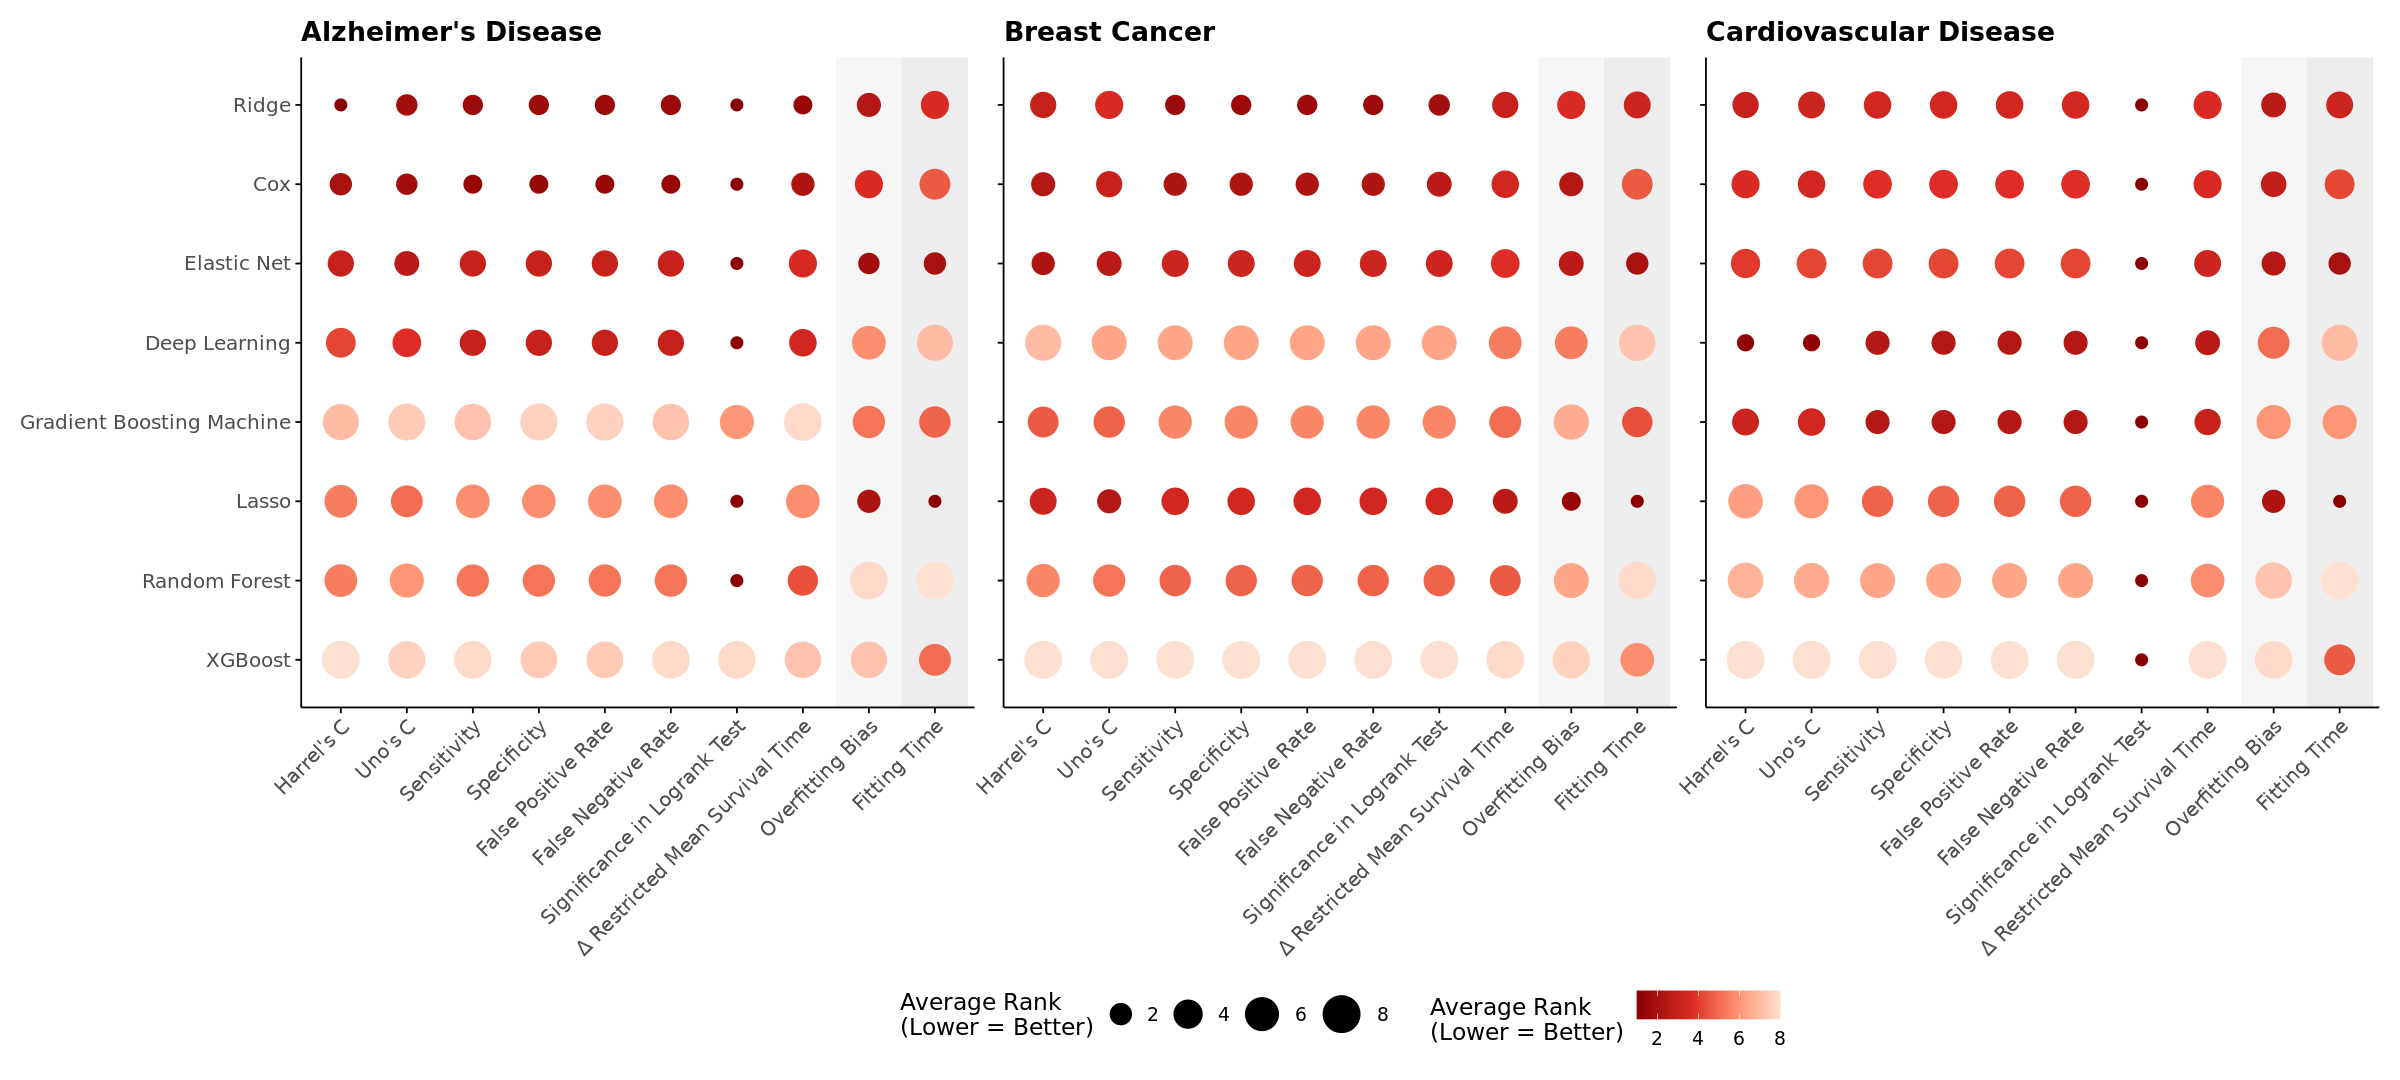

Saved and uploaded: f3b_10percentPast_Medical_History.svg

Processing Combo: PRS & Metabolomics



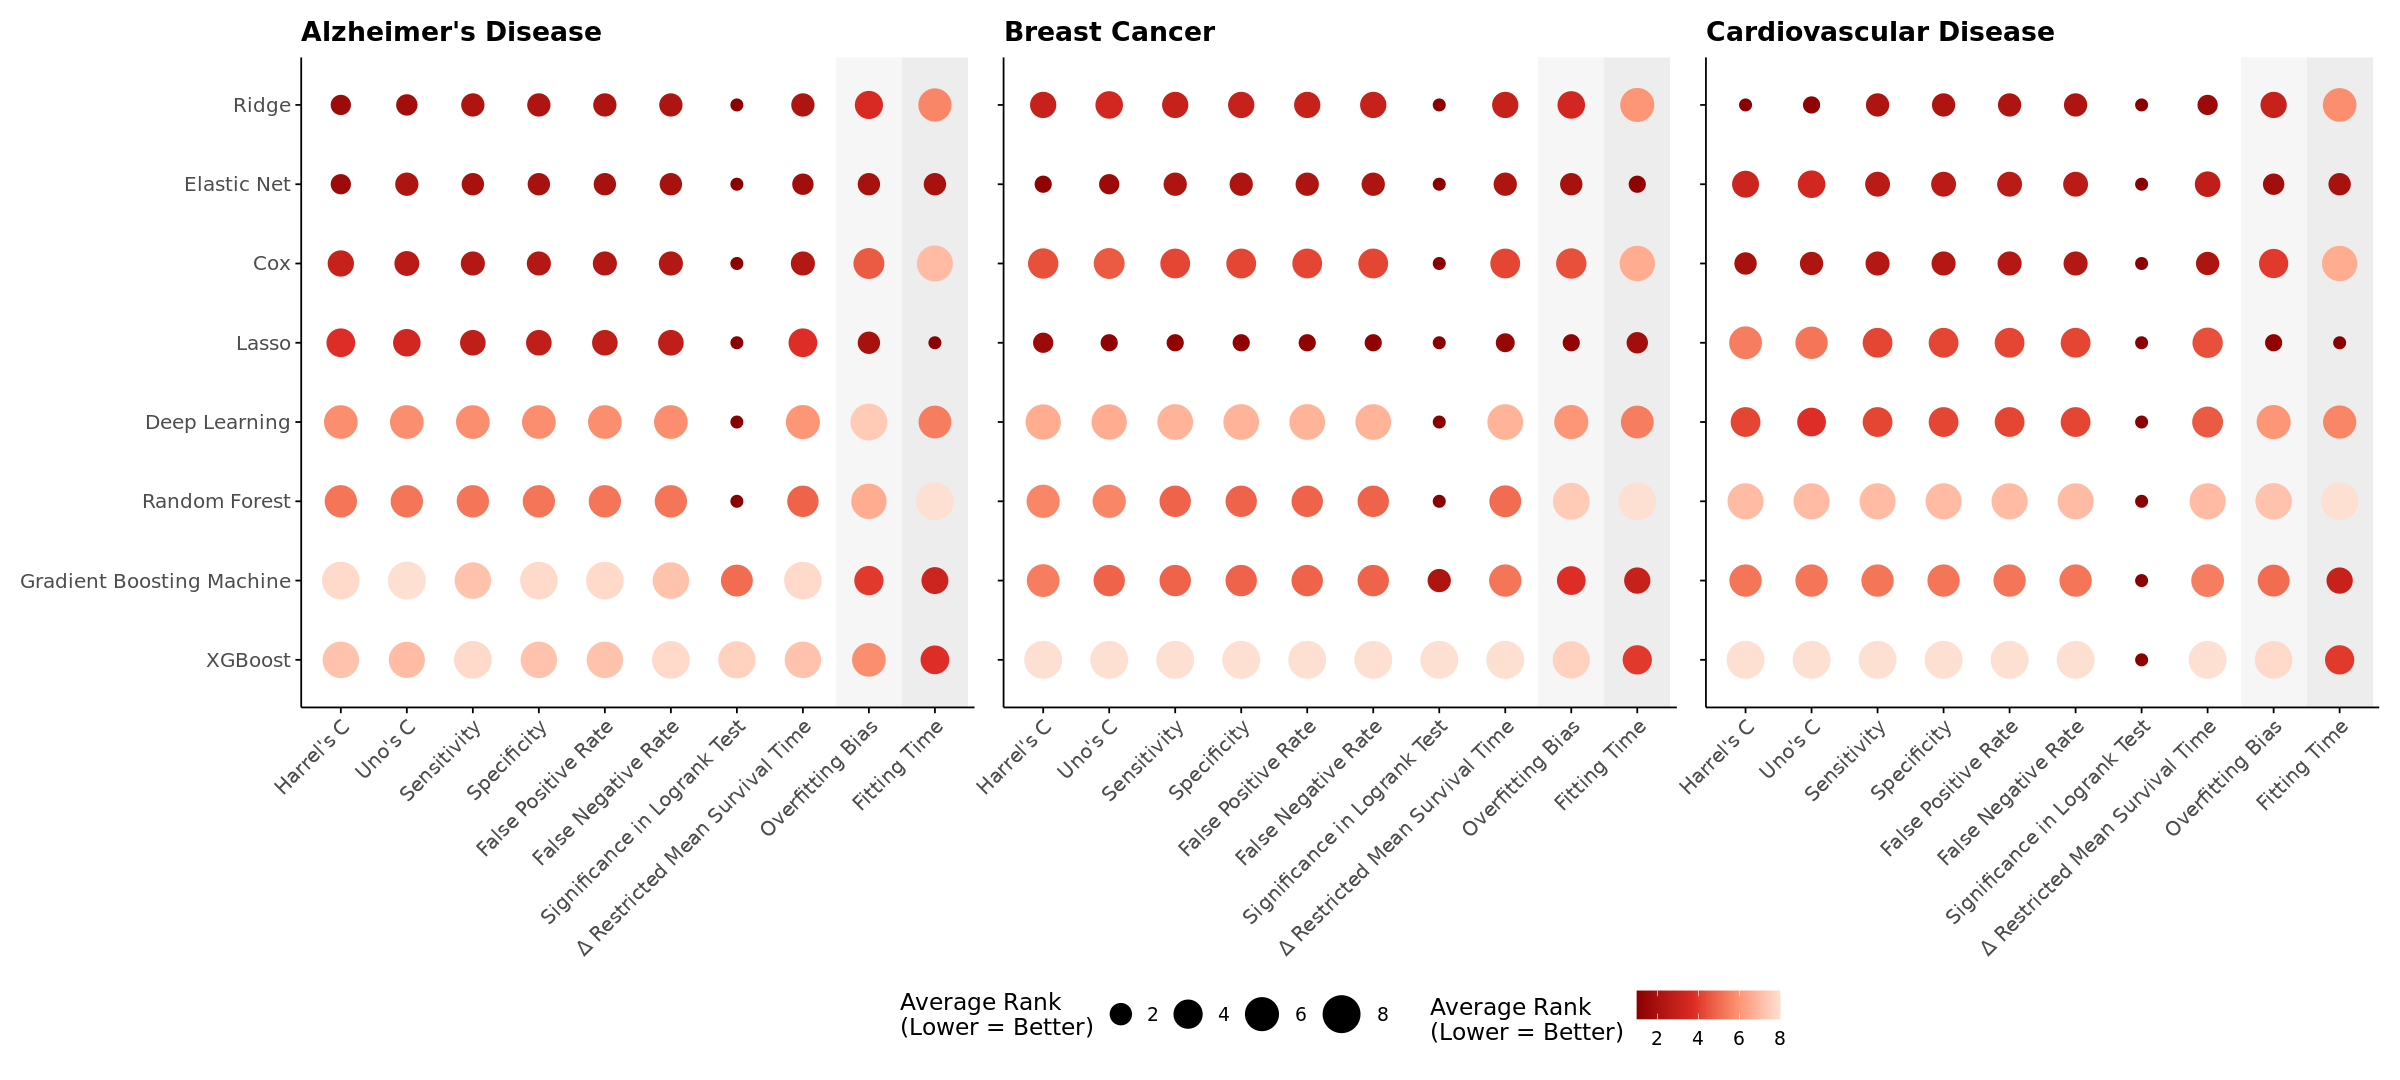

Saved and uploaded: f3b_10percentPRS___Metabolomics.svg



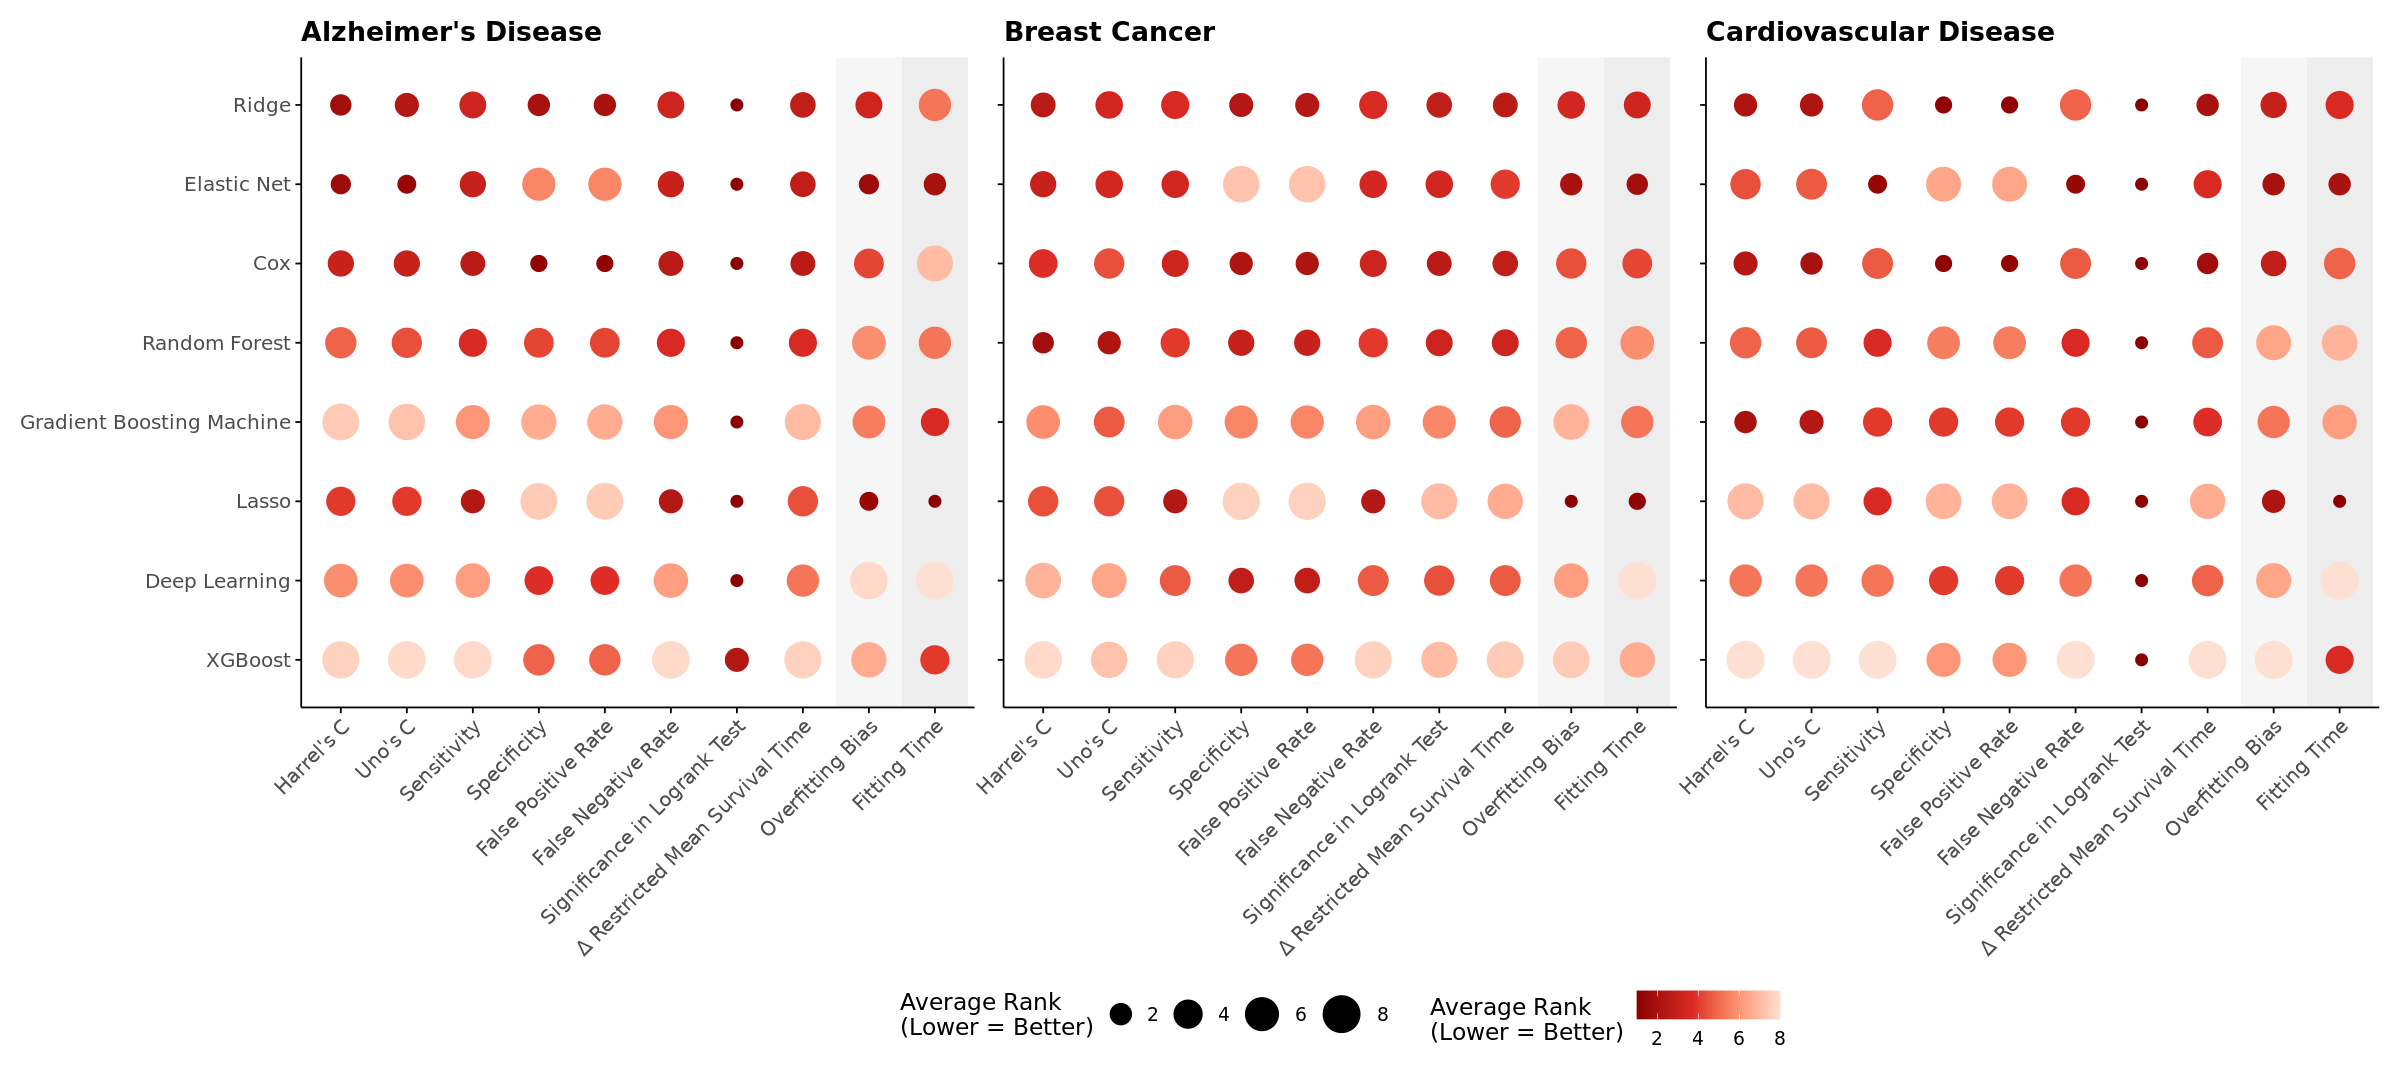

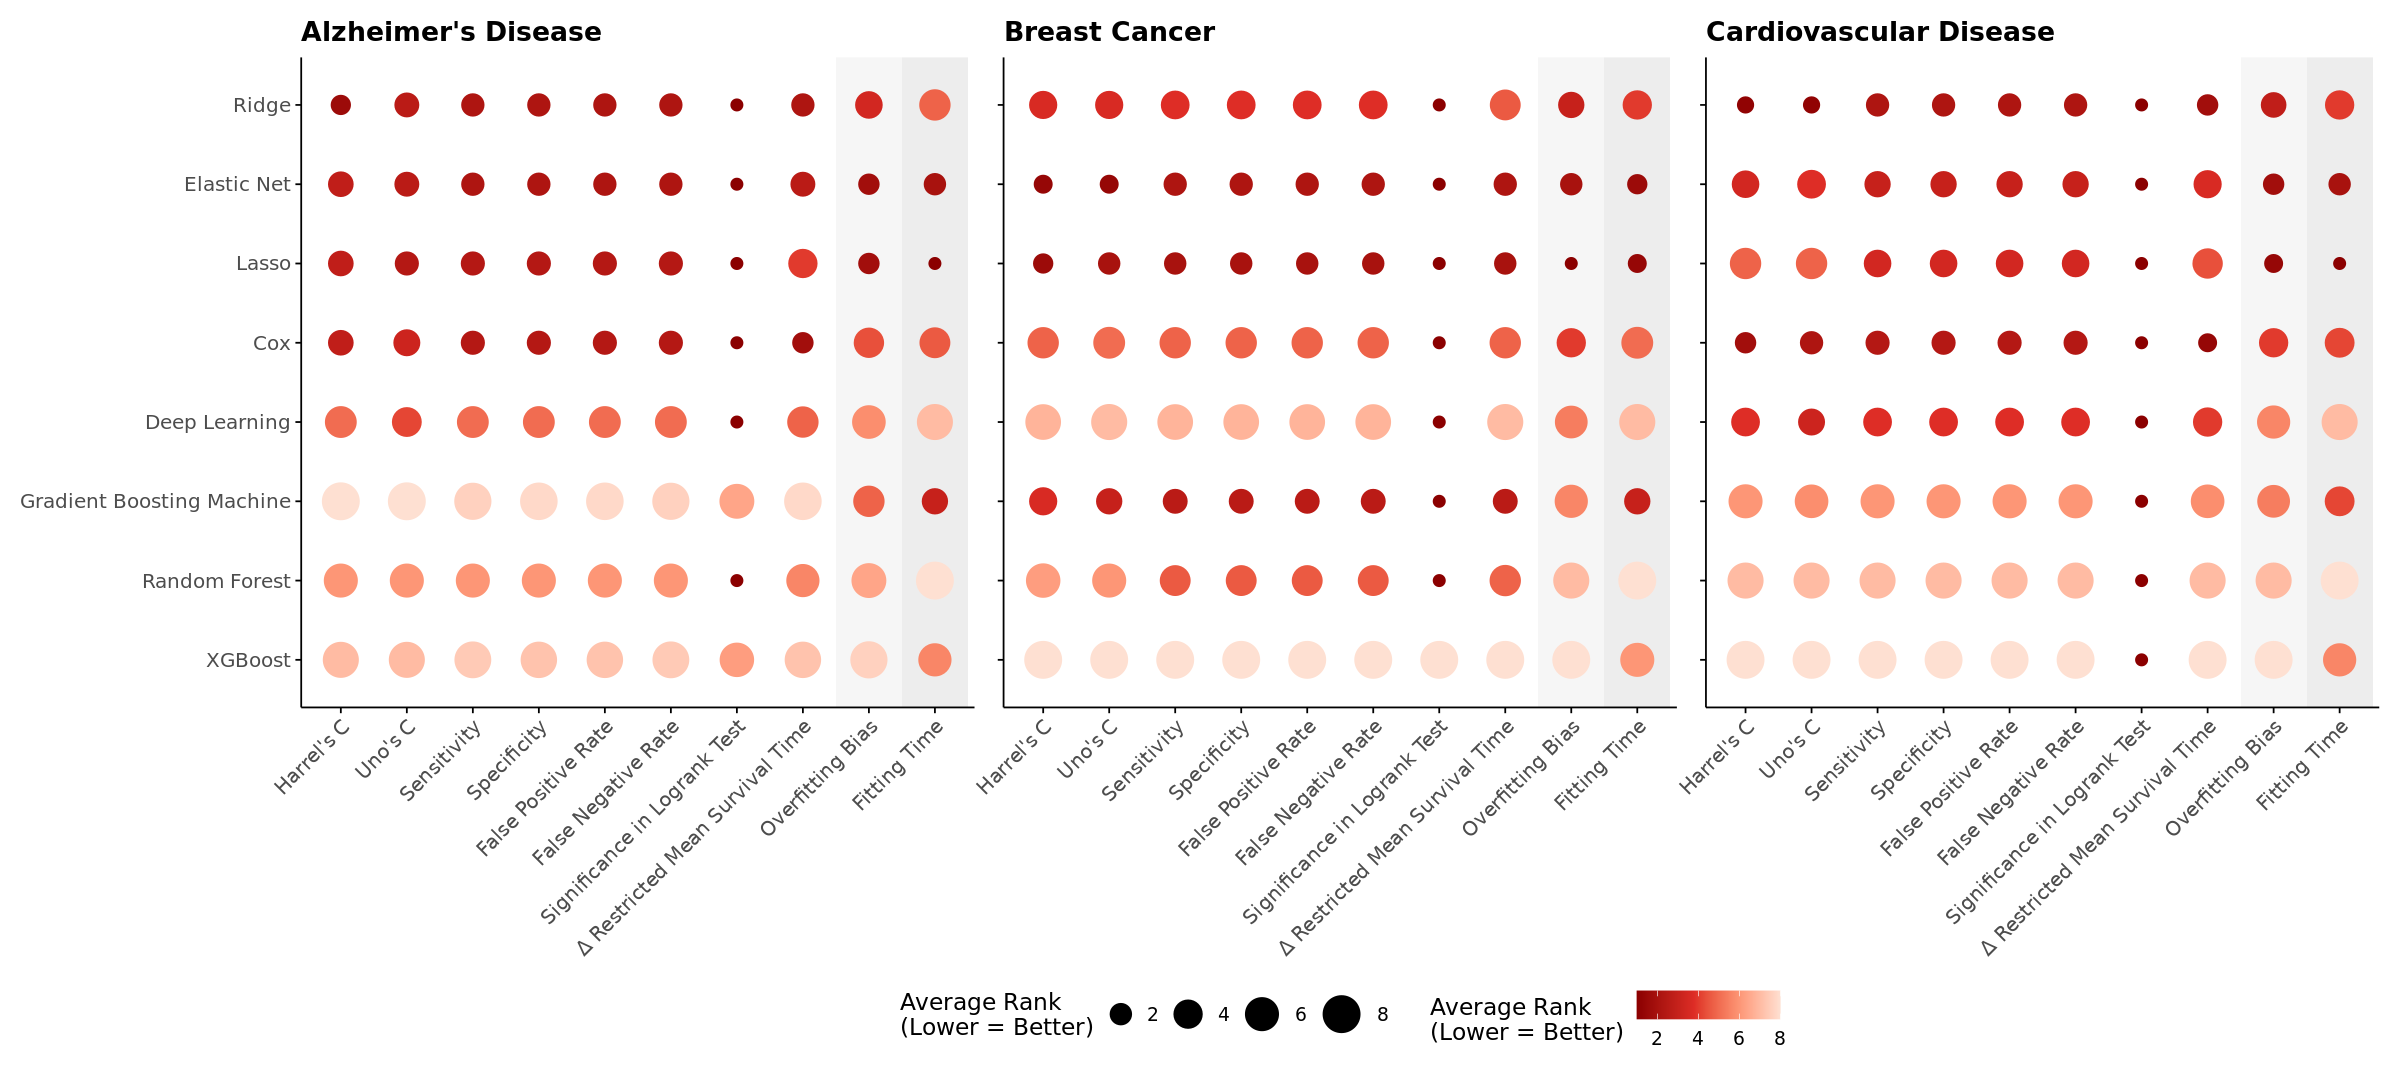

In [51]:
unique_combos <- unique(results_with_timings$combo_name)

for (curr_combo in unique_combos) {
  
  message(paste("Processing Combo:", curr_combo))
  
  results_clinical <- results_with_timings %>% 
    filter(combo_name == curr_combo)
  
  
  #reshape to long 
  results_long <- results_clinical %>%
    select(
      model_type, endpoint, cv_split,
      c_index_test,
      delta_c,
      uno_c,          
      sensitivity_10, 
      specificity_10,
      fpr_10, 
      fnr_10,
      logrank_p_val_10,
      rmst_diff_10,
      once_time
    ) %>%  
    pivot_longer(
      cols = -c(model_type, endpoint, cv_split),
      names_to = "metric",
      values_to = "value"
    )
  
  #recode metirc names
  results_long <- results_long %>%
    mutate(
      metric = case_when(
        metric == "c_index_test" ~ "Harrel's C",
        metric == "delta_c" ~ "Overfitting Bias",
        metric == "uno_c" ~ "Uno's C",  
        metric == "sensitivity_10" ~ "Sensitivity",
        metric == "specificity_10" ~ "Specificity",
        metric == "fpr_10" ~ "False Positive Rate",
        metric == "fnr_10" ~ "False Negative Rate",
        metric == "logrank_p_val_10" ~ "Significance in Logrank Test",
        metric == "rmst_diff_10" ~ "Δ Restricted Mean Survival Time",
        metric == "once_time" ~ "Fitting Time",
        TRUE ~ metric  # Retain original name if no match
      )
    )
  
  # Define metrics where lower values are better (ascending)
  ascending_metrics <- c(
    "Significance in Logrank Test", 
    "False Positive Rate", 
    "False Negative Rate", 
    "Overfitting Bias", 
    "Δ Restricted Mean Survival Time", 
    "Fitting Time"
  )
  
  # 'min' ensures that tied models receive the lowest possible rank
  results_ranked <- results_long %>%
    group_by(cv_split, endpoint, metric) %>%
    mutate(
      initial_rank = if_else(
        metric %in% ascending_metrics,
        rank(value, ties.method = "min"),    # Lower is better
        rank(-value, ties.method = "min")    # Higher is better
      )
    ) %>%
    ungroup()
  
  # Average the initial ranks across cv_splits for each model_type, endpoint, and metric
  avg_rank_df <- results_ranked %>%
    group_by(model_type, endpoint, metric) %>%
    summarize(
      avg_rank = mean(initial_rank, na.rm = TRUE),
      .groups = "drop"  # Explicitly drop grouping after summarization
    )
  
  # Reorder model_type based on Harrel's C average rank
  harrels_c_rank <- avg_rank_df %>%
    filter(metric == "Harrel's C") %>%
    group_by(model_type) %>%
    summarize(
      harrels_c_avg_rank = mean(avg_rank, na.rm = TRUE),
      .groups = "drop"
    )
  
  avg_rank_df <- avg_rank_df %>%
    left_join(harrels_c_rank, by = "model_type") %>%
    mutate(
      model_type = fct_reorder(model_type, harrels_c_avg_rank)
    )
  
  #custom metric oder 
  custom_metric_order <- c(
    "Harrel's C", 
    "Uno's C",
    "Sensitivity", 
    "Specificity", 
    "False Positive Rate", 
    "False Negative Rate", 
    "Significance in Logrank Test", 
    "Δ Restricted Mean Survival Time", 
    "Overfitting Bias",  
    "Fitting Time"       
  )
  
  # Define metrics to be highlighted with background shading
  special_metrics <- data.frame(
    metric = c("Overfitting Bias", "Fitting Time"),
    category = c("lightgrey", "darkgrey")
  ) %>%
    filter(metric %in% existing_metrics)
  
  #per endpoint plot
  unique_endpoints <- unique(avg_rank_df$endpoint)
  plot_list <- list()
  
  for(i in seq_along(unique_endpoints)){
    ep <- unique_endpoints[i]
    
    ep_data <- avg_rank_df %>% filter(endpoint == ep)
    
    ep_special_metrics <- special_metrics
    
    p <- ggplot(ep_data, aes(x = metric, y = model_type)) +
      # Draw background rectangles for specified metrics
      geom_rect(
        data = ep_special_metrics,
        aes(
          xmin = as.numeric(factor(metric, levels = custom_metric_order)) - 0.5,
          xmax = as.numeric(factor(metric, levels = custom_metric_order)) + 0.5,
          ymin = -Inf, 
          ymax = Inf, 
          fill = category
        ),
        inherit.aes = FALSE, 
        alpha = 0.2
      ) +
      # Plot the points representing average ranks
      geom_point(aes(size = avg_rank, color = avg_rank)) +
      # Define color gradient for average ranks using a colored palette
      scale_color_gradientn(
        colors = c("darkred", "#DE2D26", "#FC9272", "#FEE0D2"),  
        values = c(0, 0.4, 0.7, 1), 
        na.value = "grey90",
        name = "Average Rank\n(Lower = Better)"
      ) +
      # Use the fill colors directly from special_metrics
      scale_fill_identity() +
      # Define size scale for average ranks
      scale_size_continuous(
        range = c(3, 10),
        name = "Average Rank\n(Lower = Better)"
      ) +  
      # Invert the y-axis so the best model appears at the top
      scale_y_discrete(limits = rev(levels(ep_data$model_type))) +  
      # Define the order of metrics on the x-axis
      scale_x_discrete(limits = custom_metric_order) +
      # Apply a theme that includes axis lines
      theme_minimal(base_size = 14) +
      labs(
        x = NULL, 
        y = NULL,
        title = ep  # Use endpoint name as the plot title
      ) +
      theme(
        axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
        axis.text.y = if(i == 1) element_text(size = 12) else element_blank(),
        axis.title = element_blank(),
        axis.line = element_line(color = "black", linewidth = 0.5),
        axis.ticks = element_line(color = "black", linewidth = 0.5),
        legend.position = "bottom",
        plot.title = element_text(size = 16, face = "bold", hjust = 0),
        strip.text = element_text(size = 14, face = "bold", hjust = 0),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank()
      )
    
    plot_list[[i]] <- p
  }
  
  # Combine the plots
  n_cols <- min(length(unique_endpoints), 3)
  
  combined_plot <- wrap_plots(plot_list, ncol = n_cols) + 
    plot_layout(guides = "collect") & theme(legend.position = "bottom")
  
  print(combined_plot)
  
  # save
  safe_combo <- gsub("[^A-Za-z0-9]", "_", curr_combo)
  out_name <- paste0("f3b_10percent", safe_combo, ".svg")
  
  ggsave(
    filename = out_name, 
    plot = combined_plot, 
    width = 20, 
    height = 9, 
    units = "in", 
    dpi = 1000, 
    bg = "transparent"
  )

  uplcmd <- paste0("dx upload \"", out_name, "\" --path Benchmarking/Plots/", out_name)
  system(uplcmd)
  
  message(paste("Saved and uploaded:", out_name))
  
}

# 4. Statistical analysis

In [45]:
subsetted_results <- results_with_timings[, c("cv_split", "model_type", "endpoint", "combo_name", "c_index_test", "once_time")]

In [15]:
install.packages("tidyverse")
install.packages("car")
install.packages("afex")

if (!require("emmeans")) {
  install.packages("emmeans")
}
library(emmeans)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bit’, ‘bit64’, ‘blob’, ‘cellranger’, ‘ids’, ‘vroom’, ‘tzdb’, ‘progress’, ‘broom’, ‘conflicted’, ‘dbplyr’, ‘dtplyr’, ‘forcats’, ‘googledrive’, ‘googlesheets4’, ‘haven’, ‘hms’, ‘modelr’, ‘readr’, ‘readxl’, ‘reprex’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘Deriv’, ‘microbenchmark’, ‘Rdpack’, ‘doBy’, ‘boot’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘carData’, ‘Formula’, ‘nnet’, ‘pbkrtest’, ‘lme4’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘lmerTest’, ‘reshape2’


Loading required package: emmeans

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘emmeans’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

a

In [78]:
# Load required libraries
library(dplyr)
library(tidyr)

# Assuming `subsetted_results` is your main dataframe containing the data
# Define endpoints and combo_names
endpoints <- c("Alzheimer\'s Disease", "Breast Cancer", "Cardiovascular Disease")
combo_names <- c("Age & Sex", "Clinical Risk", "Everything", "Past Medical History", "PRS & Metabolomics")

# Loop over each endpoint and combo_name
for (endpointt in endpoints) {
    if (endpointt != "Breast Cancer") next
  for (combo_namee in combo_names) {
    # Filter data for specific endpoint and combo_name, then reshape
      if (combo_namee != "Age & Sex") next
    wide_df <- subsetted_results %>%
      filter(endpoint == endpointt, combo_name == combo_namee) %>%
      select(cv_split, model_type, c_index_test) %>%
      spread(key = model_type, value = c_index_test)
    
    # Extract model names
    model_names <- setdiff(names(wide_df), "cv_split") # excluding "cv_split"
    num_models <- length(model_names)
    num_comparisons <- choose(num_models, 2)
    p_values <- numeric(num_comparisons)
    pairwise_names <- character(num_comparisons)
    index <- 1

    # Perform paired t-tests for each model pair
    for (i in 1:(num_models - 1)) {
      for (j in (i + 1):num_models) {
        model1 <- model_names[i]
        model2 <- model_names[j]
        # Conduct paired t-test on matched pairs of data
        test_result <- t.test(wide_df[[model1]], wide_df[[model2]], paired = TRUE)
        p_values[index] <- test_result$p.value
        pairwise_names[index] <- paste(model1, "-", model2)
        index <- index + 1
      }
    }

    # Apply BH FDR adjustment
    adjusted_p_values <- p.adjust(p_values, method = "BH")

    # Create a dataframe for the results
    results_test_df <- data.frame(contrast = pairwise_names, p_value = p_values, adj_p_value = adjusted_p_values)

    # Filter the results to include only those contrasts containing "Cox - "
    filtered_results_test_df <- results_test_df %>%
      filter(grepl("Cox - ", contrast))

    # Print the context and results
    print(paste("This is the test for", endpointt, "and", combo_namee))
    print(filtered_results_test_df)
  }
}

[1] "This is the test for Breast Cancer and Age & Sex"
                         contrast     p_value adj_p_value
1             Cox - Deep Learning 0.405977296  0.44657503
2               Cox - Elastic Net         NaN         NaN
3 Cox - Gradient Boosting Machine 0.026759995  0.07358999
4                     Cox - Lasso         NaN         NaN
5             Cox - Random Forest 0.049806799  0.09131247
6                     Cox - Ridge         NaN         NaN
7                   Cox - XGBoost 0.005106012  0.02808307


In [79]:
wide_df

cv_split,Cox,Deep Learning,Elastic Net,Gradient Boosting Machine,Lasso,Random Forest,Ridge,XGBoost
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.5444747,0.5383501,0.5444747,0.5355573,0.5444747,0.5361401,0.5444747,0.5414078
2,0.5448492,0.5444656,0.5448492,0.5414491,0.5448492,0.5420016,0.5448492,0.5412044
3,0.5331800,0.5268502,0.5331800,0.5306679,0.5331800,0.5323174,0.5331800,0.5312409
4,0.5237767,0.5237674,0.5237767,0.5207871,0.5237767,0.5222005,0.5237767,0.5222927
5,0.5415335,0.5453427,0.5415335,0.5312749,0.5415335,0.5358402,0.5415335,0.5398777


In [70]:
# Load required libraries
library(dplyr)
library(tidyr)

# Define endpoints and combo_names (adjust as needed)
endpoints <- c("Alzheimer\'s Disease", "Breast Cancer", "Cardiovascular Disease")
combo_names <- c("Age & Sex", "Clinical Risk", "Everything", "Past Medical History", "PRS & Metabolomics")

# Initialize a list to store the group-wise results.
all_overview_results <- list()

for (endpointt in endpoints) {
  for (combo_namee in combo_names) {
    # Filter the data and reshape using pivot_wider.
    # The new column names will be like "c_index_test_ModelName" and "fitting_time_ModelName".
    wide_df <- subsetted_results %>%
      filter(endpoint == endpointt, combo_name == combo_namee) %>%
      select(cv_split, model_type, c_index_test, once_time) %>%
      pivot_wider(names_from = model_type, values_from = c(c_index_test, once_time))
    
    # Determine the models based on the c_index_test column names.
    model_cols <- names(wide_df)[grepl("^c_index_test_", names(wide_df))]
    # Remove the prefix to get the actual model names.
    model_names <- gsub("^c_index_test_", "", model_cols)
    num_models <- length(model_names)
    num_comparisons <- choose(num_models, 2)
    
    # Initialize vectors to store pair-wise results.
    ci_p_values <- numeric(num_comparisons)
    ft_p_values <- numeric(num_comparisons)
    contrasts_text <- character(num_comparisons)
    model1_vec <- character(num_comparisons)
    model2_vec <- character(num_comparisons)
    index <- 1  # counter
    
    # Loop over all pairs
    for(i in 1:(num_models - 1)) {
      for(j in (i + 1):num_models) {
        mod1 <- model_names[i]
        mod2 <- model_names[j]
      
        # Extract the corresponding vectors.
        vec_ci1 <- wide_df[[paste0("c_index_test_", mod1)]]
        vec_ci2 <- wide_df[[paste0("c_index_test_", mod2)]]
      
        vec_ft1 <- wide_df[[paste0("once_time_", mod1)]]
        vec_ft2 <- wide_df[[paste0("once_time_", mod2)]]
      
        # Perform paired t-tests: one for c_index_test and one for fitting_time.
        test_ci <- t.test(vec_ci1, vec_ci2, paired = TRUE)
        test_ft <- t.test(vec_ft1, vec_ft2, paired = TRUE)
      
        ci_p_values[index] <- test_ci$p.value
        ft_p_values[index] <- test_ft$p.value
        contrasts_text[index] <- paste(mod1, "-", mod2)
        model1_vec[index] <- mod1
        model2_vec[index] <- mod2
      
        index <- index + 1
      }
    }
    
    # Apply Benjamini-Hochberg FDR adjustment separately for each outcome.
    ci_adj <- p.adjust(ci_p_values, method = "BH")
    ft_adj <- p.adjust(ft_p_values, method = "BH")
    
    # Create a temporary dataframe with these results and add context columns.
    tmp <- data.frame(
      contrast = contrasts_text,
      c_index_test_p_value = ci_p_values,
      c_index_test_adj_p_value = ci_adj,
      fitting_time_p_value = ft_p_values,
      fitting_time_adj_p_value = ft_adj,
      model1 = model1_vec,
      model2 = model2_vec,
      endpoint = endpointt,
      combo_name = combo_namee,
      stringsAsFactors = FALSE
    )
    
    # Save the temporary dataframe into our results list.
    all_overview_results[[paste(endpointt, combo_namee, sep = "_")]] <- tmp
  }
}

# Combine all temporary dataframes into one overview dataframe.
overview_df <- do.call(rbind, all_overview_results)

# Subset the final dataframe to contain only the desired columns.
overview_df <- overview_df %>%
  select(endpoint, combo_name, model1, model2,
         c_index_test_p_value, c_index_test_adj_p_value,
         fitting_time_p_value, fitting_time_adj_p_value)

rownames(overview_df) <- NULL

In [71]:
head(overview_df)

,endpoint,combo_name,model1,model2,c_index_test_p_value,c_index_test_adj_p_value,fitting_time_p_value,fitting_time_adj_p_value
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Alzheimer's Disease,Age & Sex,Cox,Deep Learning,0.565964339,0.660709736,4.658834e-03,0.0072800809
2,Alzheimer's Disease,Age & Sex,Cox,Elastic Net,0.360286822,0.523461353,1.801490e-05,0.0001110025
3,Alzheimer's Disease,Age & Sex,Cox,Lasso,0.253667492,0.444374966,1.769116e-05,0.0001110025
4,Alzheimer's Disease,Age & Sex,Cox,Random Forest,0.684823031,0.737501726,6.951426e-01,0.6951425658
5,Alzheimer's Disease,Age & Sex,Cox,Ridge,0.373900966,0.523461353,1.217926e-01,0.1364076863
6,Alzheimer's Disease,Age & Sex,Cox,XGBoost,0.001216688,0.004866752,5.425605e-05,0.0002170242


In [72]:
install.packages("openxlsx")
library(openxlsx)

# Assuming overview_df is your data frame
write.xlsx(overview_df, file = "p_values_df.xlsx")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [73]:
uplcmd <- "dx upload p_values_df.xlsx --path Benchmarking/p_values_df.xlsx"
system(uplcmd)